# Unsupervised Learning Trading Strategy

1. Download/Load SP500 stocks prices data.
2. Calculate different features and indicators on each stock.
3. Aggregate on monthly level and filter top 150 most liquid stocks.
4. Calculate Monthly Returns for different time-horizons.
5. Download Fama-French Factors and Calculate Rolling Factor Betas.
6. For each month fit a K-Means Clustering Algorithm to group similar assets based on their features.
7. For each month select assets based on the cluster and form a portfolio based on Efficient Frontier max sharpe ratio optimization.
8. Visualize Portfolio returns and compare to SP500 returns.

In [1]:
from statsmodels.regression.rolling import RollingOLS
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import pandas_ta
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')

# 1. Download/Load SP500 stocks prices data.

The S&P 500, or Standard & Poor's 500, is a stock market index that tracks the performance of 500 of the largest publicly traded companies in the United States. It is widely regarded as a benchmark for the overall U.S. stock market and the economy. The index covers diverse industries, including technology, healthcare, finance, and consumer goods. It is market-capitalization-weighted, meaning larger companies have a greater impact on the index's performance. Investors and analysts use the S&P 500 to gauge market trends, compare investment returns, and make economic forecasts.

In [2]:
sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]

sp500['Symbol'] = sp500['Symbol'].str.replace('.', '-')

symbol_list = sp500['Symbol'].unique().tolist() # Contains Survivorship bias

Survivorship bias in the context of the S&P 500 stock list refers to the tendency to analyze or consider only those companies that have survived over a certain period and are currently included in the index, while ignoring those that were once part of the index but have since been removed. This can lead to skewed or overly optimistic conclusions about the performance and characteristics of the index because it fails to account for the companies that did not survive due to poor performance, bankruptcy, mergers, or other reasons.

### Key Points of Survivorship Bias in S&P 500

1. **Exclusion of Failed Companies**: When analyzing the S&P 500, the focus is often on the companies that are currently in the index. This excludes companies that were once part of the index but were removed because they underperformed, went bankrupt, or were acquired. This exclusion can make historical performance appear better than it actually was.

2. **Overestimation of Performance**: Since the S&P 500 tends to retain successful companies and drop unsuccessful ones, historical analyses based on the current list of S&P 500 companies may overestimate the index's past performance. This is because it doesn't reflect the losses from companies that failed or were removed from the index.

3. **Misleading Risk Assessment**: Survivorship bias can lead to an underestimation of the risks involved. Investors might believe that the S&P 500 is less risky than it actually is if they do not consider the companies that failed and were removed from the index.

4. **Inaccurate Backtesting**: When backtesting investment strategies using the current list of S&P 500 companies, the results can be misleading. The backtest does not account for the companies that did not survive, thus presenting an incomplete picture of potential outcomes.

### Example

Suppose an investor looks at the historical performance of the S&P 500 index and sees strong returns over the past 30 years. If they only consider the companies currently in the index, they are ignoring companies that were part of the index at some point but were later removed due to poor performance or other reasons. This leads to an overestimation of the index's true historical performance.

### Mitigating Survivorship Bias

1. **Use Historical Constituents Data**: To get a more accurate picture, use historical data that includes all companies that have ever been part of the S&P 500, not just those that are currently included. This data should account for the companies that were added and removed over time.

2. **Consider Delisted Companies**: Include the performance of companies that were delisted, went bankrupt, or were acquired. This provides a more comprehensive view of the risks and returns associated with the index.

3. **Adjusted Indices**: Some financial data providers offer adjusted indices that attempt to account for survivorship bias by including data on companies that have been removed from the index.

### Practical Approach

For academic research, financial analysis, or backtesting investment strategies, it is crucial to consider survivorship bias. Researchers and analysts often rely on databases that track historical constituents of indices like the S&P 500, including the companies that were removed. This helps in producing more accurate and realistic analyses and strategies.

In summary, survivorship bias in the S&P 500 stock list can significantly distort our understanding of the index's historical performance and risk. By recognizing and accounting for this bias, investors and analysts can make more informed decisions.

In [3]:
end_date = datetime.today() #'2023-09-27'
start_date = pd.to_datetime(end_date) - pd.DateOffset(365*8)

In [4]:
df = yf.download(tickers=symbol_list,
                start = start_date,
                end = end_date).stack()
df.index.names = ['date', 'ticker']
df.columns = df.columns.str.lower()
df.dropna(inplace=True)
df

[*********************100%%**********************]  503 of 503 completed


Price               adj close       close        high         low        open  \
date       ticker                                                               
2016-07-08 A        42.710800   45.480000   45.549999   44.860001   44.860001   
           AAL      28.869143   30.040001   30.280001   29.700001   29.799999   
           AAPL     22.199820   24.170000   24.222500   24.012501   24.122499   
           ABBV     45.469193   64.160004   64.480003   62.740002   63.480000   
           ABT      36.155434   41.889999   42.270000   41.560001   41.599998   
...                       ...         ...         ...         ...         ...   
2024-07-05 XYL     134.259995  134.259995  134.300003  131.119995  132.550003   
           YUM     129.119995  129.119995  129.690002  128.229996  129.320007   
           ZBH     108.010002  108.010002  108.160004  106.169998  106.820000   
           ZBRA    310.510010  310.510010  312.429993  308.700012  312.250000   
           ZTS     174.960007  174.960007  175.960007  174.250000  175.199997   

Price                   volume  
date       ticker               
2016-07-08 A         1838100.0  
           AAL      13659300.0  
           AAPL    115648400.0  
           ABBV      7921700.0  
           ABT      11071800.0  
...                        ...  
2024-07-05 XYL       1106300.0  
           YUM       1477600.0  
           ZBH       1045000.0  
           ZBRA       245700.0  
           ZTS       1812100.0  

[991896 rows x 6 columns]

# 2. Calculate features and technical indicators for each stock.
- Garman-Klass Volatility
- RSI
- Bollinger Bands
- ATR
- MACD
- Dollar Volume

## Garman-Klass Volatility

The Garman-Klass volatility is a method used to estimate historical volatility, primarily in the context of financial markets. It was proposed by Garman and Klass in their 1980 paper titled "On the Estimation of Security Price Volatilities from Historical Data."

The Garman-Klass volatility is calculated using the following formula:

\begin{equation}
\text{Garman-Klass Volatility} = \sqrt{ \frac{1}{n} \sum_{i=1}^{n} ( \frac{(\ln(\text{$High_i$}) - \ln(\text{$Low_i$}))^2}{2} - (2\ln(2) - 1)(\ln(\text{$Adj\_Close_i$}) - \ln(\text{$Open_i$}))^2 )}
\end{equation}

Where:
- $High_i$  is the high price of the asset on day $i$,
- $Low_i$ is the low price of the asset on day $i$, 
- $Adj\_Close_i$ is the closing price of the asset on day $i$, 
- $Open_i$ is the opening price of the asset on day $i$, and 
- $n$ is the number of days over which the volatility is being calculated. 

### Interpretation

The Garman-Klass volatility measures the historical volatility of an asset based on its price movements over a specific period. It considers both the range of price fluctuations (high and low prices) and the relationship between opening and closing prices. The higher the volatility, the greater the price variability of the asset.

### Advantages

- **Incorporates Price Range**: The Garman-Klass volatility considers the high and low prices of the asset, providing a more comprehensive view of price movements.
  
- **Accounts for Open-Close Price Relation**: It takes into account the relationship between opening and closing prices, which can provide additional insights into market dynamics.

### Limitations

- **Sensitive to Outliers**: Like other historical volatility estimators, the Garman-Klass volatility can be sensitive to extreme price movements or outliers, potentially leading to distorted volatility estimates.

- **Assumes Log-Normality**: The formula assumes that price returns are log-normally distributed, which may not always hold true in practice, especially during periods of market stress.

### Use Cases

The Garman-Klass volatility is commonly used in finance and investment for risk management, options pricing, and portfolio optimization. Traders and analysts use historical volatility measures like Garman-Klass to assess the riskiness of assets, adjust trading strategies, and make informed investment decisions.

### Summary

The Garman-Klass volatility is a widely used method for estimating historical volatility in financial markets. By incorporating both price range and the relationship between opening and closing prices, it provides a comprehensive measure of asset price variability over a given period. Despite its limitations, it remains a valuable tool for risk assessment and decision-making in the financial industry.

In [5]:
df['garman_klass_vol'] = ((np.log(df['high'])-np.log(df['low']))**2)/2-(2*np.log(2)-1)*((np.log(df['adj close'])-np.log(df['open']))**2)

## Concept of RSI
The Relative Strength Index (RSI) is a technical indicator used to measure the magnitude of recent price changes to evaluate overbought or oversold conditions in a stock or market index like the S&P 500. It was developed by J. Welles Wilder Jr. and introduced in his 1978 book, "New Concepts in Technical Trading Systems."

The RSI is calculated using the following formula:

$$
RSI = 100 - \left( \frac{100}{1 + \frac{\text{Average Gain}}{\text{Average Loss}}} \right)
$$

Where:
- Average Gain = Average of gains over a specified period (usually 14 days)
- Average Loss = Average of losses over the same period

### Interpretation of RSI

- **Overbought Condition**: When the RSI value is above 70, it suggests that the stock or index may be overbought, meaning that it has risen too far too quickly, and a reversal or pullback may be imminent.

- **Oversold Condition**: When the RSI value is below 30, it suggests that the stock or index may be oversold, meaning that it has fallen too far too quickly, and a rebound or rally may be imminent.

### Application to S&P 500 Stocks

Traders and investors use the RSI to analyze individual stocks within the S&P 500 index to identify potential buying or selling opportunities. For example:

- **Short-term Trading**: Traders may use RSI signals to identify short-term trading opportunities based on overbought or oversold conditions.

- **Confirmation Tool**: RSI can be used in conjunction with other technical indicators or fundamental analysis to confirm potential trend reversals or continuation patterns in S&P 500 stocks.

- **Divergence Analysis**: Traders may look for divergence between the price action of an S&P 500 stock and its RSI reading to anticipate trend reversals or changes in momentum.

### Considerations

- **Period Length**: The period used to calculate the RSI (usually 14 days) can be adjusted based on the trader's preference or the specific characteristics of the stock being analyzed.

- **False Signals**: RSI signals should be used in conjunction with other technical indicators or analysis methods to avoid relying solely on RSI for trading decisions, as false signals can occur, especially in choppy or sideways markets.

### Summary

The Relative Strength Index (RSI) is a popular technical indicator used by traders and investors to analyze the strength and momentum of price movements in individual stocks, including those within the S&P 500 index. By identifying overbought and oversold conditions, RSI can help traders anticipate potential trend reversals or continuation patterns in S&P 500 stocks, providing valuable insights for trading decisions.

In [6]:
length=20
df['rsi'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.rsi(close=x, length=length))

## Components of Bollinger Bands

Bollinger Bands are a popular technical analysis tool developed by John Bollinger in the 1980s. They consist of a set of lines plotted at certain standard deviations (usually two) above and below a simple moving average (SMA) of a security's price. Bollinger Bands are used to measure market volatility and to identify potential overbought or oversold conditions.

1. **Middle Band**: This is the simple moving average (SMA) of the price, typically calculated over 20 periods.
   
   $$
   \text{Middle Band} = \text{SMA}_{20}
   $$

2. **Upper Band**: This is the middle band plus two standard deviations.
   
   $$
   \text{Upper Band} = \text{SMA}_{20} + 2 \times \text{Standard Deviation}
   $$

3. **Lower Band**: This is the middle band minus two standard deviations.
   
   $$
   \text{Lower Band} = \text{SMA}_{20} - 2 \times \text{Standard Deviation}
   $$

### Interpretation

- **Volatility Measurement**: The width of the bands increases when the market is volatile and decreases during less volatile periods. Wider bands indicate higher volatility, while narrower bands indicate lower volatility.

- **Overbought and Oversold Conditions**:
  - When the price moves above the upper band, it may indicate that the asset is overbought.
  - When the price moves below the lower band, it may indicate that the asset is oversold.

- **Trend Reversal Signals**: Prices moving persistently close to the upper or lower band can signal the continuation of the current trend. Conversely, moves that start at one band and travel all the way to the opposite band can signal a trend reversal.

### Trading Strategies Using Bollinger Bands

1. **Mean Reversion**: Traders may buy when the price touches the lower band and sell when it touches the upper band, expecting the price to revert to the mean (middle band).

2. **Breakout Strategy**: Traders may look for breakouts above the upper band or below the lower band, expecting significant price movements to continue in the breakout direction.

3. **Bollinger Band Squeeze**: A squeeze occurs when the bands come close together, indicating low volatility. This is often followed by a period of high volatility and potential trading opportunities.


### Summary

Bollinger Bands are a versatile and widely-used technical analysis tool that helps traders and investors measure market volatility and identify potential overbought or oversold conditions. By using Bollinger Bands, traders can gain insights into market dynamics and make more informed trading decisions.

In [7]:
df['bb_low'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=length).iloc[:,0])
                                                          
df['bb_mid'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=length).iloc[:,1])
                                                          
df['bb_high'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=length).iloc[:,2])

## Average True Range (ATR)

The Average True Range (ATR) is a technical analysis indicator developed by J. Welles Wilder Jr. It measures market volatility by decomposing the entire range of an asset price for a given period. The ATR is primarily used to assess the degree of price volatility and is often employed to set stop-loss levels and inform trading decisions.

### Calculating ATR

The ATR is calculated using the following steps:

1. **True Range (TR)**: The true range for a given period is the greatest of the following three values:
   - The difference between the current high and the current low.
   - The absolute value of the difference between the current high and the previous close.
   - The absolute value of the difference between the current low and the previous close.
   
   Mathematically:
   $$
   TR = \max(\text{High} - \text{Low}, |\text{High} - \text{Previous Close}|, |\text{Low} - \text{Previous Close}|)
   $$

2. **Average True Range (ATR)**: The ATR is then calculated as the moving average of the true ranges over a specified number of periods. Wilder originally recommended a 14-day period.

   $$
   ATR = \frac{1}{n} \sum_{i=1}^{n} TR_i
   $$

### Interpretation of ATR

- **Volatility Indicator**: ATR provides a measure of volatility. Higher ATR values indicate higher volatility, whereas lower ATR values indicate lower volatility.
- **No Trend Indication**: Unlike some other indicators, the ATR does not provide any indication of the direction of the price movement, just the degree of volatility.
- **Setting Stop-Loss Levels**: Traders often use ATR to set stop-loss levels. A common approach is to set the stop-loss a certain multiple of the ATR below (for long positions) or above (for short positions) the entry price.

### Summary

The Average True Range (ATR) is a valuable indicator for measuring market volatility. It provides insights into the magnitude of price fluctuations and is widely used by traders to set stop-loss levels and assess the volatility of an asset. The ATR's primary advantage is its ability to capture the true range of price movements, making it a robust tool for volatility analysis.

In [9]:
def compute_atr(stock_data):
    atr = pandas_ta.atr(high=stock_data['high'],
                        low=stock_data['low'],
                        close=stock_data['close'],
                        length=14)
    return atr.sub(atr.mean()).div(atr.std())

In [11]:
df['atr'] = df.groupby(level=1, group_keys=False).apply(compute_atr)

## MACD

The Moving Average Convergence Divergence (MACD) is a trend-following momentum indicator that shows the relationship between two moving averages of a security's price. It was developed by Gerald Appel in the late 1970s. The MACD is calculated by subtracting the 26-period Exponential Moving Average (EMA) from the 12-period EMA. A nine-period EMA of the MACD, called the "signal line," is then plotted on top of the MACD line, which can function as a trigger for buy and sell signals.

### Components of MACD

1. **MACD Line**: The difference between the 12-period EMA and the 26-period EMA.
   $$
   \text{MACD} = \text{EMA}_{12} - \text{EMA}_{26}
   $$

2. **Signal Line**: The 9-period EMA of the MACD line.
   $$
   \text{Signal Line} = \text{EMA}_9(\text{MACD})
   $$

3. **Histogram**: The difference between the MACD line and the Signal line.
   $$
   \text{Histogram} = \text{MACD} - \text{Signal Line}
   $$

### Interpretation

- **Buy Signal**: When the MACD line crosses above the Signal line.
- **Sell Signal**: When the MACD line crosses below the Signal line.
- **Divergence**: When the security price diverges from the MACD. For example, the price is making new highs while the MACD is not, which could indicate a potential reversal.
- **Overbought/Oversold**: When the MACD is significantly above or below its baseline, it indicates that the price may be overbought or oversold.

### Summary

The Moving Average Convergence Divergence (MACD) is a versatile and widely-used momentum indicator in technical analysis. It helps traders identify potential buy and sell signals, gauge the strength of market trends, and spot potential reversals. By using `pandas_ta`, you can easily calculate and visualize the MACD for any time series data, facilitating more informed trading decisions.

In [12]:
def calculate_macd(close):
    macd = pandas_ta.macd(close=close, length=length).iloc[:,0]
    return macd.sub(macd.mean()).div(macd.std())

In [13]:
df['macd'] = df.groupby(level=1, group_keys=False)['adj close'].apply(calculate_macd)

Dollar Volume is a financial metric that represents the total value of all traded shares of a particular stock over a specified period. It is calculated by multiplying the number of shares traded by the stock's price. Dollar Volume provides insight into the liquidity and trading activity of a stock, indicating how much money is being traded in that stock.

### Calculation of Dollar Volume

The formula to calculate Dollar Volume is:

$$
\text{Dollar Volume} = \text{Price} \times \text{Volume}
$$

Where:
- **Price** is the trading price of the stock.
- **Volume** is the total number of shares traded.

### Importance of Dollar Volume

1. **Liquidity Assessment**: A higher Dollar Volume indicates higher liquidity, meaning the stock can be bought or sold more easily without significantly affecting its price.
2. **Market Interest**: Stocks with high Dollar Volume are typically more attractive to investors and traders as they are more actively traded.
3. **Volatility Indicator**: Changes in Dollar Volume can signal changes in volatility. An increasing Dollar Volume might indicate growing investor interest or concern, leading to higher volatility.
4. **Trade Execution**: For large trades, understanding Dollar Volume helps in executing orders with minimal market impact.

### Summary

Dollar Volume is a crucial metric in financial analysis, providing insights into a stock's liquidity, trading activity, and market interest. It is calculated by multiplying the trading volume by the stock price. High Dollar Volume generally indicates higher liquidity and investor interest, making it an essential tool for traders and investors when evaluating stocks and planning trades.

In [14]:
df['dollar_volume'] = (df['adj close']*df['volume'])/1e6
df

Price               adj close       close        high         low        open  \
date       ticker                                                               
2016-07-08 A        42.710800   45.480000   45.549999   44.860001   44.860001   
           AAL      28.869143   30.040001   30.280001   29.700001   29.799999   
           AAPL     22.199820   24.170000   24.222500   24.012501   24.122499   
           ABBV     45.469193   64.160004   64.480003   62.740002   63.480000   
           ABT      36.155434   41.889999   42.270000   41.560001   41.599998   
...                       ...         ...         ...         ...         ...   
2024-07-05 XYL     134.259995  134.259995  134.300003  131.119995  132.550003   
           YUM     129.119995  129.119995  129.690002  128.229996  129.320007   
           ZBH     108.010002  108.010002  108.160004  106.169998  106.820000   
           ZBRA    310.510010  310.510010  312.429993  308.700012  312.250000   
           ZTS     174.960007  174.960007  175.960007  174.250000  175.199997   

Price                   volume  garman_klass_vol        rsi    bb_low  \
date       ticker                                                       
2016-07-08 A         1838100.0         -0.000815        NaN       NaN   
           AAL      13659300.0         -0.000202        NaN       NaN   
           AAPL    115648400.0         -0.002627        NaN       NaN   
           ABBV      7921700.0         -0.042639        NaN       NaN   
           ABT      11071800.0         -0.007457        NaN       NaN   
...                        ...               ...        ...       ...   
2024-07-05 XYL       1106300.0          0.000224  45.011493  4.889272   
           YUM       1477600.0          0.000063  34.055505  4.858185   
           ZBH       1045000.0          0.000125  38.410755  4.653470   
           ZBRA       245700.0          0.000060  53.177470  5.693120   
           ZTS       1812100.0          0.000047  54.566066  5.123913   

Price                bb_mid   bb_high       atr      macd  dollar_volume  
date       ticker                                                         
2016-07-08 A            NaN       NaN       NaN       NaN      78.506722  
           AAL          NaN       NaN       NaN       NaN     394.332279  
           AAPL         NaN       NaN       NaN       NaN    2567.373613  
           ABBV         NaN       NaN       NaN       NaN     360.193302  
           ABT          NaN       NaN       NaN       NaN     400.305730  
...                     ...       ...       ...       ...            ...  
2024-07-05 XYL     4.928299  4.967326  0.839423 -1.072289     148.531832  
           YUM     4.908755  4.959325  0.139565 -1.728948     190.787705  
           ZBH     4.692822  4.732174 -0.806713 -0.890784     112.870452  
           ZBRA    5.722956  5.752792 -0.298862 -0.070620      76.292309  
           ZTS     5.160925  5.197938  0.705878  0.236783     317.045028  

[991896 rows x 14 columns]

## 3. Aggregate to monthly level and filter top 150 most liquid stocks for each month.


In [15]:
operational_cols =  [c for c in df.columns.unique(0) if c not in ['dollar_volume', 'volume', 'open','high', 'low', 'close']]

In [16]:
data = pd.concat([df.unstack('ticker')['dollar_volume'].resample('M').mean().stack('ticker').to_frame('dollar_volume'),
                   df.unstack()[operational_cols].resample('M').last().stack('ticker')],
                 axis=1).dropna()
data

dollar_volume   adj close       atr   bb_high    bb_low  \
date       ticker                                                            
2016-08-31 A           87.662071   44.119476 -1.375228  3.842369  3.799092   
           AAL        269.710266   34.989563  0.005668  3.624501  3.511263   
           AAPL      2718.975596   24.494839 -1.324817  3.275645  3.235305   
           ABBV       309.214755   45.825459 -1.521095  3.908017  3.843967   
           ABT        377.320457   36.491039 -1.202936  3.715369  3.629980   
...                          ...         ...       ...       ...       ...   
2024-07-31 XYL        146.656246  134.259995  0.839423  4.967326  4.889272   
           YUM        244.239966  129.119995  0.139565  4.959325  4.858185   
           ZBH        165.323056  108.010002 -0.806713  4.732174  4.653470   
           ZBRA        64.312926  310.510010 -0.298862  5.752792  5.693120   
           ZTS        310.061875  174.960007  0.705878  5.197938  5.123913   

                     bb_mid  garman_klass_vol      macd        rsi  
date       ticker                                                   
2016-08-31 A       3.820731         -0.001640 -0.131101  49.085383  
           AAL     3.567882         -0.000479  0.628356  58.454831  
           AAPL    3.255475         -0.002162 -0.118804  56.501446  
           ABBV    3.875992         -0.043844 -0.281959  39.824237  
           ABT     3.672675         -0.009720 -0.304716  34.921720  
...                     ...               ...       ...        ...  
2024-07-31 XYL     4.928299          0.000224 -1.072289  45.011493  
           YUM     4.908755          0.000063 -1.728948  34.055505  
           ZBH     4.692822          0.000125 -0.890784  38.410755  
           ZBRA    5.722956          0.000060 -0.070620  53.177470  
           ZTS     5.160925          0.000047  0.236783  54.566066  

[47352 rows x 9 columns]

* Calculate 5-year rolling average of dollar volume for each stocks before filtering.

In [17]:
data['dollar_volume'] = (data.loc[:, 'dollar_volume'].unstack('ticker').rolling(5*12, min_periods=12).mean().stack())

data['dollar_vol_rank'] = (data.groupby('date')['dollar_volume'].rank(ascending=False))

data = data[data['dollar_vol_rank']<150].drop(['dollar_volume', 'dollar_vol_rank'], axis=1)

data

adj close       atr   bb_high    bb_low    bb_mid  \
date       ticker                                                       
2017-07-31 AAL      48.955452  0.802439  3.990058  3.892343  3.941201   
           AAPL     34.805630 -1.154694  3.616847  3.533293  3.575070   
           ABBV     51.918221 -1.282946  4.031401  3.968483  3.999942   
           ABT      43.763508 -1.328769  3.843769  3.759048  3.801408   
           ACN     115.969177 -1.251401  4.777047  4.711845  4.744446   
...                       ...       ...       ...       ...       ...   
2024-07-31 VZ       41.270000 -0.627337  3.759875  3.698250  3.729063   
           WFC      59.619999  0.353646  4.126277  4.044142  4.085210   
           WMT      70.040001  1.353844  4.254243  4.201761  4.228002   
           XOM     113.370003  0.453677  4.770199  4.695178  4.732689   
           ZTS     174.960007  0.705878  5.197938  5.123913  5.160925   

                   garman_klass_vol      macd        rsi  
date       ticker                                         
2017-07-31 AAL            -0.000281  0.306072  49.738408  
           AAPL           -0.002001 -0.181780  50.672270  
           ABBV           -0.036168 -0.110959  45.182829  
           ABT            -0.005979  0.295309  55.958981  
           ACN            -0.004038  0.092479  60.835401  
...                             ...       ...        ...  
2024-07-31 VZ              0.000052  0.593643  56.207534  
           WFC             0.000252  0.188627  52.822933  
           WMT             0.000154  1.859874  69.246723  
           XOM             0.000100 -0.105252  48.755326  
           ZTS             0.000047  0.236783  54.566066  

[12665 rows x 8 columns]

## 4. Calculate Monthly Returns for different time horizons as features.

* To capture time series dynamics that reflect, for example, momentum patterns, we compute historical returns using the method .pct_change(lag), that is, returns over various monthly periods as identified by lags.

In [18]:
def calculate_returns(df):

    outlier_cutoff = 0.005
    lags = [1, 2, 3, 6, 9, 12]
    
    for lag in lags:
        df[f'return_{lag}m'] = (df['adj close']
                              .pct_change(lag)
                              .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                                     upper=x.quantile(1-outlier_cutoff)))
                              .add(1)
                              .pow(1/lag)
                              .sub(1))
    return df
     
data = data.groupby(level=1, group_keys=False).apply(calculate_returns).dropna()
data 

adj close       atr   bb_high    bb_low    bb_mid  \
date       ticker                                                       
2018-07-31 AAL      38.702709  0.797647  3.699472  3.591910  3.645691   
           AAPL     45.223690 -1.077856  3.860463  3.808181  3.834322   
           ABBV     70.902946  0.043525  4.341630  4.234662  4.288146   
           ABT      59.436665 -0.943109  4.114918  4.021121  4.068020   
           ACN     146.102768 -0.838632  5.058385  4.997519  5.027952   
...                       ...       ...       ...       ...       ...   
2024-07-31 VRTX    474.570007  1.401704  6.187449  6.144082  6.165765   
           VZ       41.270000 -0.627337  3.759875  3.698250  3.729063   
           WFC      59.619999  0.353646  4.126277  4.044142  4.085210   
           WMT      70.040001  1.353844  4.254243  4.201761  4.228002   
           XOM     113.370003  0.453677  4.770199  4.695178  4.732689   

                   garman_klass_vol      macd        rsi  return_1m  \
date       ticker                                                     
2018-07-31 AAL             0.000092 -0.292267  49.117682   0.041623   
           AAPL           -0.000885 -0.167589  52.605281   0.027983   
           ABBV           -0.025348 -0.727461  45.920964   0.005633   
           ABT            -0.003467  0.532793  62.882447   0.079433   
           ACN            -0.003209 -0.173136  42.887828  -0.026041   
...                             ...       ...        ...        ...   
2024-07-31 VRTX            0.000041  1.005346  60.129597   0.012481   
           VZ              0.000052  0.593643  56.207534   0.000727   
           WFC             0.000252  0.188627  52.822933   0.003873   
           WMT             0.000154  1.859874  69.246723   0.034411   
           XOM             0.000100 -0.105252  48.755326  -0.015202   

                   return_2m  return_3m  return_6m  return_9m  return_12m  
date       ticker                                                          
2018-07-31 AAL     -0.047041  -0.026289  -0.050880  -0.017899   -0.019393  
           AAPL     0.009109   0.049478   0.022909   0.014540    0.022060  
           ABBV    -0.029587  -0.011801  -0.028860   0.005495    0.026310  
           ABT      0.034388   0.042361   0.010427   0.022867    0.025837  
           ACN      0.011460   0.017611   0.000037   0.013581    0.019435  
...                      ...        ...        ...        ...         ...  
2024-07-31 VRTX     0.020898   0.065056   0.015247   0.030507    0.025128  
           VZ       0.001457   0.014805  -0.001627   0.021774    0.020655  
           WFC     -0.002506   0.003599   0.031332   0.048528    0.024058  
           WMT      0.032030   0.057975   0.042039   0.029537    0.024247  
           XOM     -0.016727  -0.011343   0.019371   0.010620    0.007545  

[10507 rows x 14 columns]

### Fama-French Factors and Rolling Factor Betas

#### Fama-French Factors

The Fama-French factors are a set of factors that are used to explain stock returns. The model was developed by Eugene Fama and Kenneth French and expands on the Capital Asset Pricing Model (CAPM) by adding additional factors to better capture the risks associated with stock returns. The most common version of the model is the Fama-French Three-Factor Model, which includes:

1. **Market Risk Premium (RMRF)**: The excess return of the market over the risk-free rate.
2. **Size Factor (SMB - Small Minus Big)**: The difference in returns between small-cap and large-cap stocks. This captures the size effect, where small-cap stocks tend to outperform large-cap stocks.
3. **Value Factor (HML - High Minus Low)**: The difference in returns between high book-to-market ratio (value) stocks and low book-to-market ratio (growth) stocks. This captures the value effect, where value stocks tend to outperform growth stocks.

The Five-Factor Model extends this further by adding two more factors:

4. **Profitability Factor (RMW - Robust Minus Weak)**: The difference in returns between firms with robust (high) and weak (low) profitability.
5. **Investment Factor (CMA - Conservative Minus Aggressive)**: The difference in returns between firms that invest conservatively and those that invest aggressively.

#### Rolling Factor Betas

Rolling factor betas involve estimating the sensitivity (beta) of an asset's returns to these factors over a moving window of time. This allows for a dynamic understanding of how the asset's risk exposures change over time. Rolling betas are calculated by performing rolling regressions of the asset's returns on the factors.

### Summary

- **Fama-French Factors**: A set of factors (market, size, value, profitability, and investment) used to explain stock returns beyond the traditional CAPM model.
- **Rolling Factor Betas**: Estimating the sensitivity of an asset's returns to the Fama-French factors over a rolling window to capture dynamic risk exposures.
- **Code Explanation**:
  - Fetches Fama-French 5-factor data from the `famafrench` dataset.
  - Drops the risk-free rate column.
  - Converts the index to timestamps and resamples to monthly frequency.
  - Joins the factor data with asset returns and sorts by date.

This code essentially prepares a dataset of Fama-French factors and asset returns for further analysis, such as calculating rolling betas or performing factor regression.

## 5. Download Fama-French Factors and Calculate Rolling Factor Betas.

* We will introduce the Fama—French data to estimate the exposure of assets to common risk factors using linear regression.

* The five Fama—French factors, namely market risk, size, value, operating profitability, and investment have been shown empirically to explain asset returns and are commonly used to assess the risk/return profile of portfolios. Hence, it is natural to include past factor exposures as financial features in models.

* We can access the historical factor returns using the pandas-datareader and estimate historical exposures using the RollingOLS rolling linear regression.

In [19]:
factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3',
                               'famafrench',
                               start='2010')[0].drop('RF', axis=1)

factor_data.index = factor_data.index.to_timestamp()

factor_data = factor_data.resample('M').last().div(100)

factor_data.index.name = 'date'

factor_data = factor_data.join(data['return_1m']).sort_index()

factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2018-07-31 AAL     0.0319 -0.0193  0.0047  0.0156  0.0035   0.041623
           AAPL    0.0319 -0.0193  0.0047  0.0156  0.0035   0.027983
           ABBV    0.0319 -0.0193  0.0047  0.0156  0.0035   0.005633
           ABT     0.0319 -0.0193  0.0047  0.0156  0.0035   0.079433
           ACN     0.0319 -0.0193  0.0047  0.0156  0.0035  -0.026041
...                   ...     ...     ...     ...     ...        ...
2024-05-31 VRTX    0.0434  0.0059 -0.0133  0.0321 -0.0287   0.159186
           VZ      0.0434  0.0059 -0.0133  0.0321 -0.0287   0.042036
           WFC     0.0434  0.0059 -0.0133  0.0321 -0.0287   0.015922
           WMT     0.0434  0.0059 -0.0133  0.0321 -0.0287   0.111839
           XOM     0.0434  0.0059 -0.0133  0.0321 -0.0287  -0.000487

[10223 rows x 6 columns]

* Filter out stocks with less than 10 months of data.

In [20]:
observations = factor_data.groupby(level=1).size()

valid_stocks = observations[observations >= 10]

factor_data = factor_data[factor_data.index.get_level_values('ticker').isin(valid_stocks.index)]

factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2018-07-31 AAL     0.0319 -0.0193  0.0047  0.0156  0.0035   0.041623
           AAPL    0.0319 -0.0193  0.0047  0.0156  0.0035   0.027983
           ABBV    0.0319 -0.0193  0.0047  0.0156  0.0035   0.005633
           ABT     0.0319 -0.0193  0.0047  0.0156  0.0035   0.079433
           ACN     0.0319 -0.0193  0.0047  0.0156  0.0035  -0.026041
...                   ...     ...     ...     ...     ...        ...
2024-05-31 VRTX    0.0434  0.0059 -0.0133  0.0321 -0.0287   0.159186
           VZ      0.0434  0.0059 -0.0133  0.0321 -0.0287   0.042036
           WFC     0.0434  0.0059 -0.0133  0.0321 -0.0287   0.015922
           WMT     0.0434  0.0059 -0.0133  0.0321 -0.0287   0.111839
           XOM     0.0434  0.0059 -0.0133  0.0321 -0.0287  -0.000487

[10181 rows x 6 columns]

* Calculate Rolling Factor Betas.

In [21]:
betas = (factor_data.groupby(level=1,
                            group_keys=False)
         .apply(lambda x: RollingOLS(endog=x['return_1m'], 
                                     exog=sm.add_constant(x.drop('return_1m', axis=1)),
                                     window=min(24, x.shape[0]),
                                     min_nobs=len(x.columns)+1)
         .fit(params_only=True)
         .params
         .drop('const', axis=1)))

betas 

Mkt-RF       SMB       HML       RMW       CMA
date       ticker                                                  
2018-07-31 AAL          NaN       NaN       NaN       NaN       NaN
           AAPL         NaN       NaN       NaN       NaN       NaN
           ABBV         NaN       NaN       NaN       NaN       NaN
           ABT          NaN       NaN       NaN       NaN       NaN
           ACN          NaN       NaN       NaN       NaN       NaN
...                     ...       ...       ...       ...       ...
2024-05-31 VRTX    0.392347  0.763705 -0.574362  0.647316  0.505625
           VZ      0.484128 -0.864954  0.243821  0.220609  0.058600
           WFC     1.081662  0.184095  1.299961 -0.616454 -0.772450
           WMT     0.573129 -0.030581  0.000608  0.770718 -0.001393
           XOM     0.797737 -0.087301  0.436583  0.739678  0.542567

[10181 rows x 5 columns]

* Join the rolling factors data to the main features dataframe.

In [22]:
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']

data = (data.join(betas.groupby('ticker').shift()))

data.loc[:, factors] = data.groupby('ticker', group_keys=False)[factors].apply(lambda x: x.fillna(x.mean()))

data = data.drop('adj close', axis=1)

data = data.dropna()

data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 10306 entries, (Timestamp('2018-07-31 00:00:00'), 'AAL') to (Timestamp('2024-07-31 00:00:00'), 'XOM')
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   atr               10306 non-null  float64
 1   bb_high           10306 non-null  float64
 2   bb_low            10306 non-null  float64
 3   bb_mid            10306 non-null  float64
 4   garman_klass_vol  10306 non-null  float64
 5   macd              10306 non-null  float64
 6   rsi               10306 non-null  float64
 7   return_1m         10306 non-null  float64
 8   return_2m         10306 non-null  float64
 9   return_3m         10306 non-null  float64
 10  return_6m         10306 non-null  float64
 11  return_9m         10306 non-null  float64
 12  return_12m        10306 non-null  float64
 13  Mkt-RF            10306 non-null  float64
 14  SMB               10306 non-null  float64
 15  HML        

## 6. For each month fit a K-Means Clustering Algorithm to group similar assets based on their features.

### K-Means Clustering
* You may want to initialize predefined centroids for each cluster based on your research.

* For visualization purpose of this tutorial we will initially rely on the ‘k-means++’ initialization.

* Then we will pre-define our centroids for each cluster.

* Long and Short Portfolio
* Form Portfilio Each Mount

In [23]:
from sklearn.cluster import KMeans

In [29]:
def get_clusters(df, initial_centroids):
    # 4 cluster for K-Means, How to decide number of clusters?
    df['cluster'] = KMeans(n_clusters=4, random_state=0, init=initial_centroids).fit(df).labels_

    return df

In [26]:
data = data.dropna().groupby('date', group_keys=False).apply(get_clusters, 'random')
data

atr   bb_high    bb_low    bb_mid  garman_klass_vol  \
date       ticker                                                             
2018-07-31 AAL     0.797647  3.699472  3.591910  3.645691          0.000092   
           AAPL   -1.077856  3.860463  3.808181  3.834322         -0.000885   
           ABBV    0.043525  4.341630  4.234662  4.288146         -0.025348   
           ABT    -0.943109  4.114918  4.021121  4.068020         -0.003467   
           ACN    -0.838632  5.058385  4.997519  5.027952         -0.003209   
...                     ...       ...       ...       ...               ...   
2024-07-31 VRTX    1.401704  6.187449  6.144082  6.165765          0.000041   
           VZ     -0.627337  3.759875  3.698250  3.729063          0.000052   
           WFC     0.353646  4.126277  4.044142  4.085210          0.000252   
           WMT     1.353844  4.254243  4.201761  4.228002          0.000154   
           XOM     0.453677  4.770199  4.695178  4.732689          0.000100   

                       macd        rsi  return_1m  return_2m  return_3m  \
date       ticker                                                         
2018-07-31 AAL    -0.292267  49.117682   0.041623  -0.047041  -0.026289   
           AAPL   -0.167589  52.605281   0.027983   0.009109   0.049478   
           ABBV   -0.727461  45.920964   0.005633  -0.029587  -0.011801   
           ABT     0.532793  62.882447   0.079433   0.034388   0.042361   
           ACN    -0.173136  42.887828  -0.026041   0.011460   0.017611   
...                     ...        ...        ...        ...        ...   
2024-07-31 VRTX    1.005346  60.129597   0.012481   0.020898   0.065056   
           VZ      0.593643  56.207534   0.000727   0.001457   0.014805   
           WFC     0.188627  52.822933   0.003873  -0.002506   0.003599   
           WMT     1.859874  69.246723   0.034411   0.032030   0.057975   
           XOM    -0.105252  48.755326  -0.015202  -0.016727  -0.011343   

                   return_6m  return_9m  return_12m    Mkt-RF       SMB  \
date       ticker                                                         
2018-07-31 AAL     -0.050880  -0.017899   -0.019393  1.202351  1.530399   
           AAPL     0.022909   0.014540    0.022060  1.318291 -0.329362   
           ABBV    -0.028860   0.005495    0.026310  0.477698  0.507593   
           ABT      0.010427   0.022867    0.025837  0.787038 -0.128992   
           ACN      0.000037   0.013581    0.019435  1.213826 -0.190196   
...                      ...        ...         ...       ...       ...   
2024-07-31 VRTX     0.015247   0.030507    0.025128  0.509072  0.092526   
           VZ      -0.001627   0.021774    0.020655  0.468967 -0.455634   
           WFC      0.031332   0.048528    0.024058  1.087871 -0.099203   
           WMT      0.042039   0.029537    0.024247  0.616885 -0.391020   
           XOM      0.019371   0.010620    0.007545  1.068891  0.144632   

                        HML       RMW       CMA  cluster  
date       ticker                                         
2018-07-31 AAL     0.397098  0.197188  0.824601        0  
           AAPL   -0.628102  0.427303  0.622960        2  
           ABBV   -0.202950  0.535460  0.469459        0  
           ABT    -0.439233  0.243587  0.934217        3  
           ACN    -0.253431  0.340773  0.082098        0  
...                     ...       ...       ...      ...  
2024-07-31 VRTX   -0.891222  0.067718  0.853537        0  
           VZ      0.229411  0.187554  0.226240        0  
           WFC     1.566559 -0.737992 -0.867370        0  
           WMT    -0.373266  0.212562  0.684859        1  
           XOM     0.842899 -0.485049  0.435617        2  

[10306 rows x 19 columns]

In [27]:
def plot_cluster(data):
    cluster_0 = data[data['cluster']==0]
    cluster_1 = data[data['cluster']==1]
    cluster_2 = data[data['cluster']==2]
    cluster_3 = data[data['cluster']==3]

    plt.scatter(cluster_0.iloc[:,0] , cluster_0.iloc[:,6] , color = 'red', label='cluster 0')
    plt.scatter(cluster_1.iloc[:,0] , cluster_1.iloc[:,6] , color = 'green', label='cluster 1')
    plt.scatter(cluster_2.iloc[:,0] , cluster_2.iloc[:,6] , color = 'blue', label='cluster 2')
    plt.scatter(cluster_3.iloc[:,0] , cluster_3.iloc[:,6] , color = 'black', label='cluster 3')
    
    plt.legend()
    plt.show()
    return

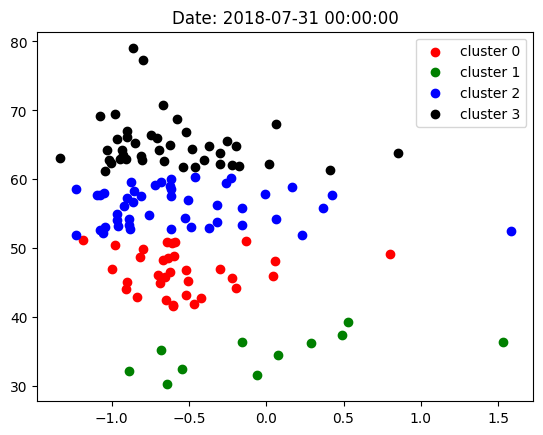

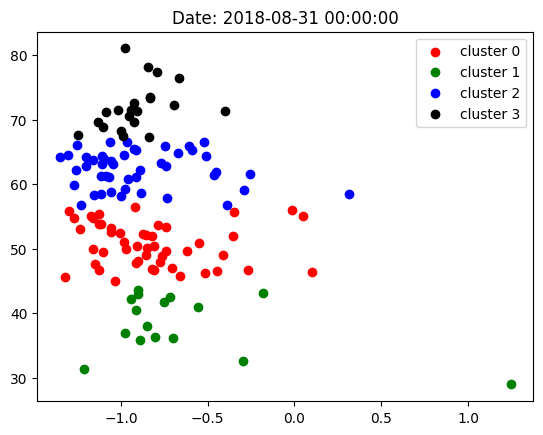

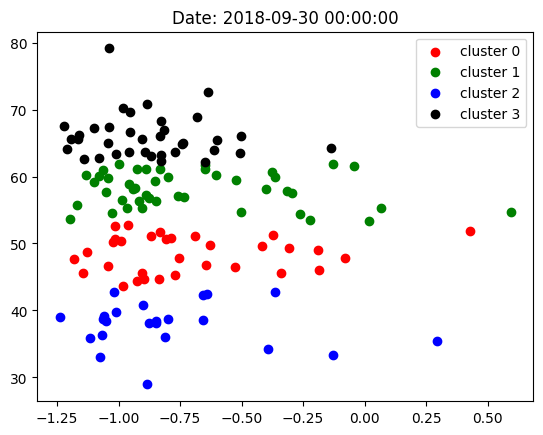

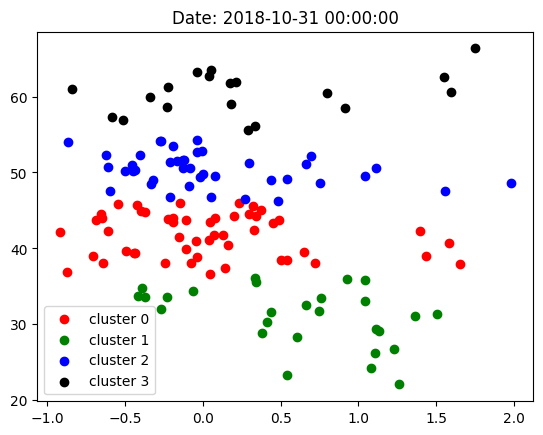

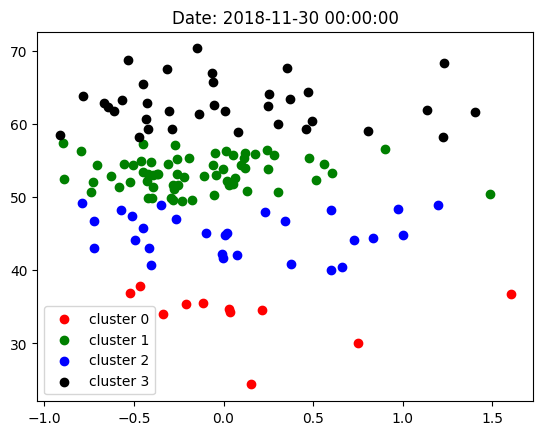

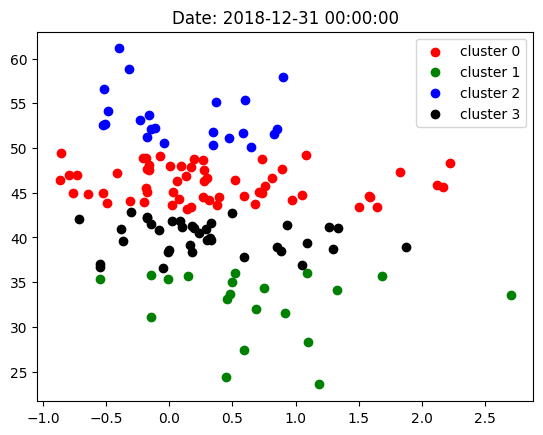

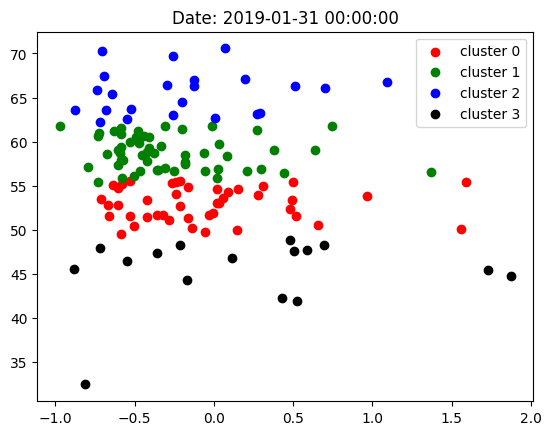

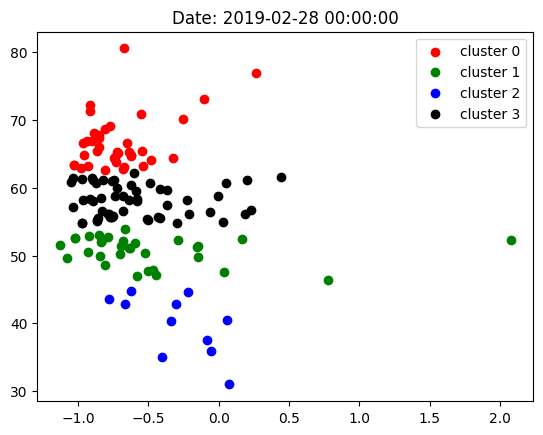

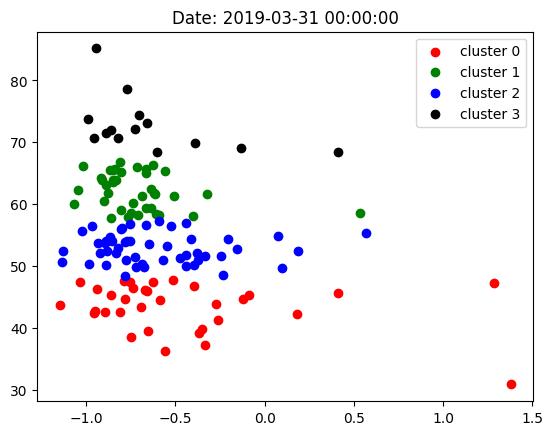

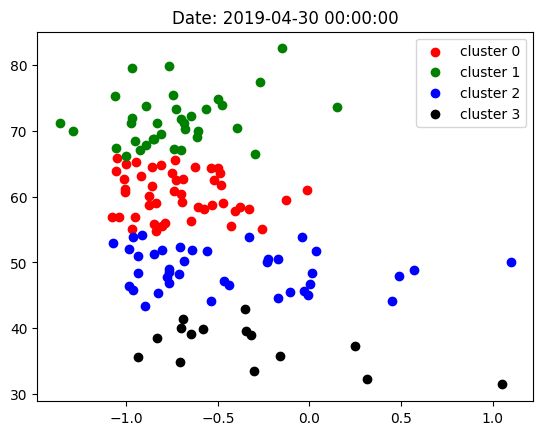

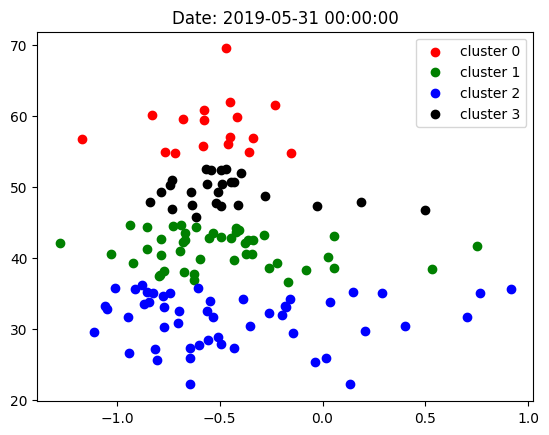

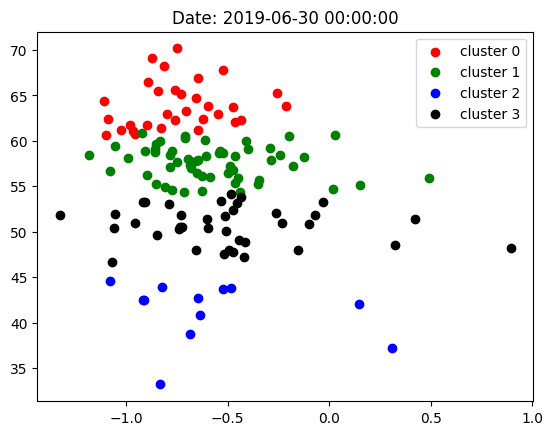

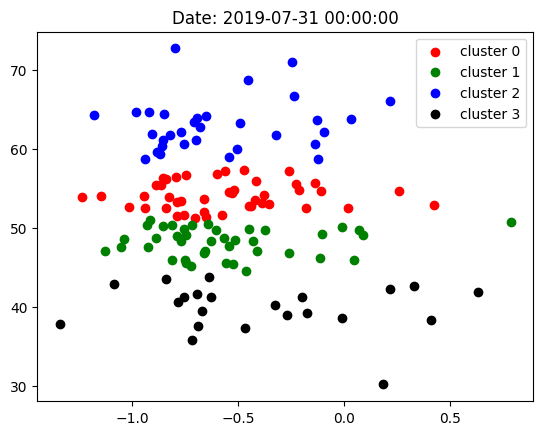

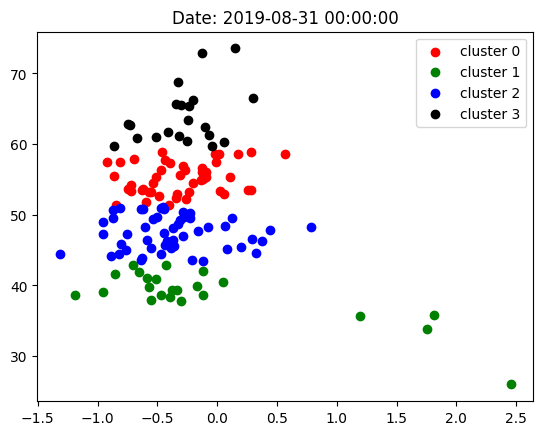

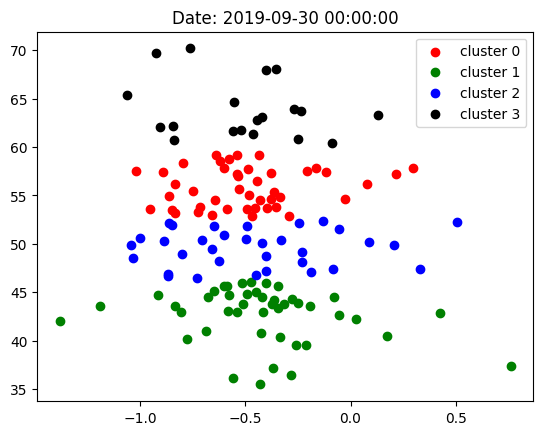

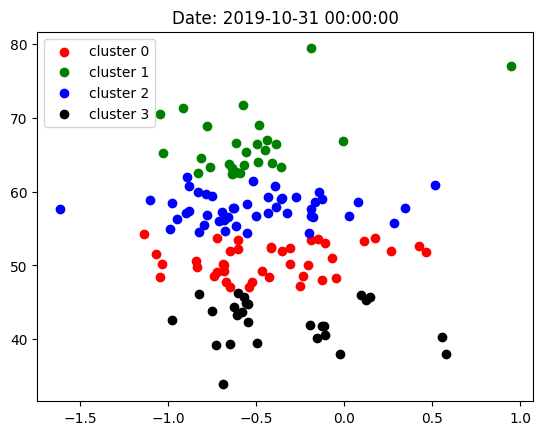

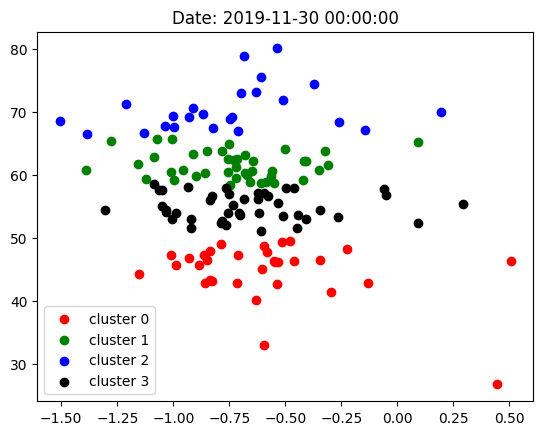

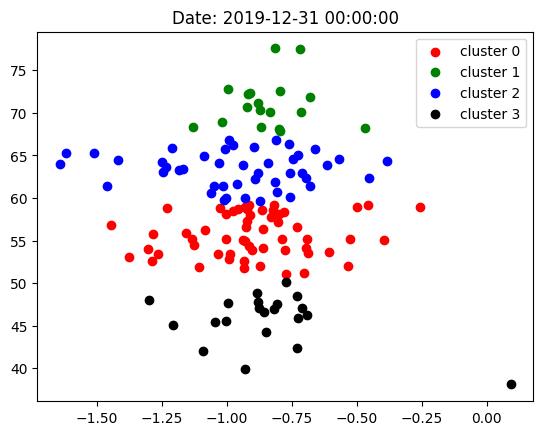

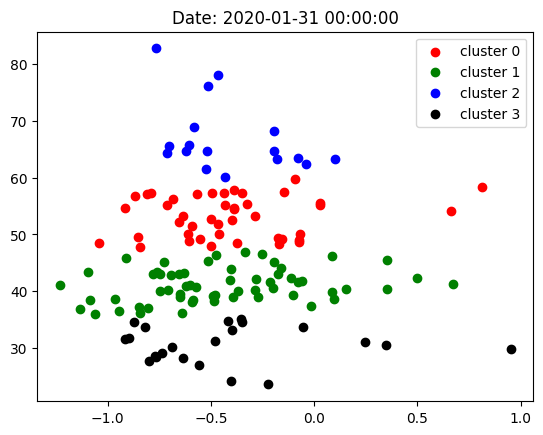

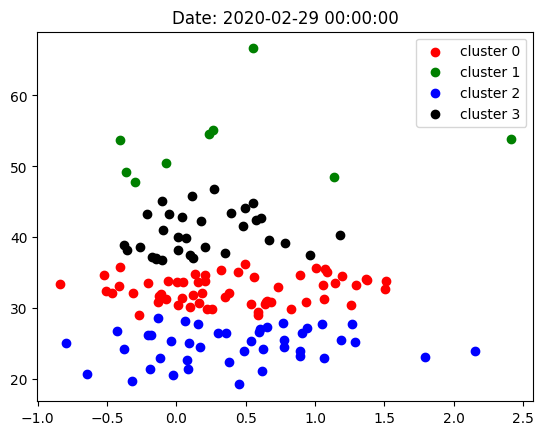

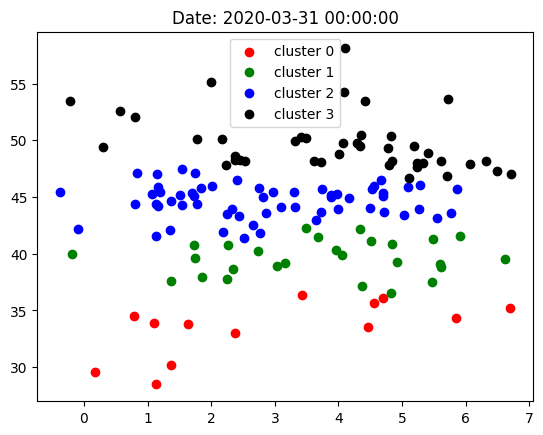

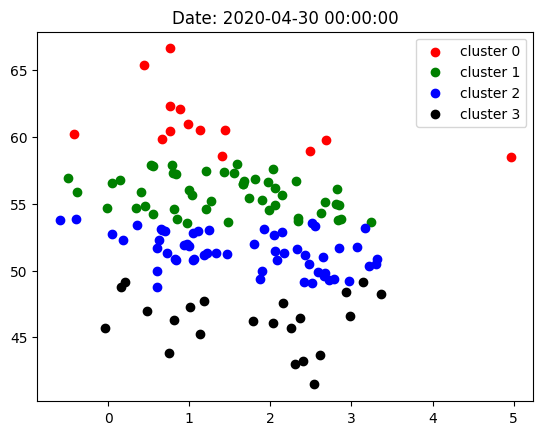

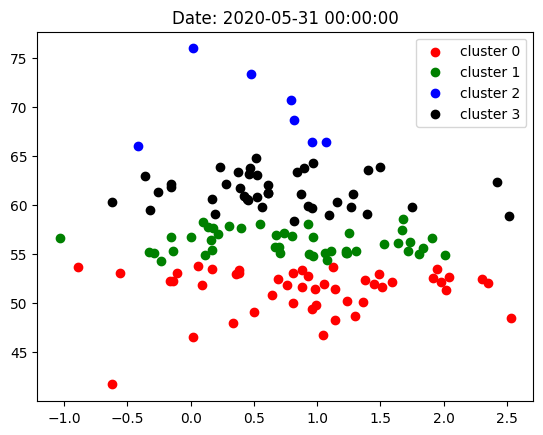

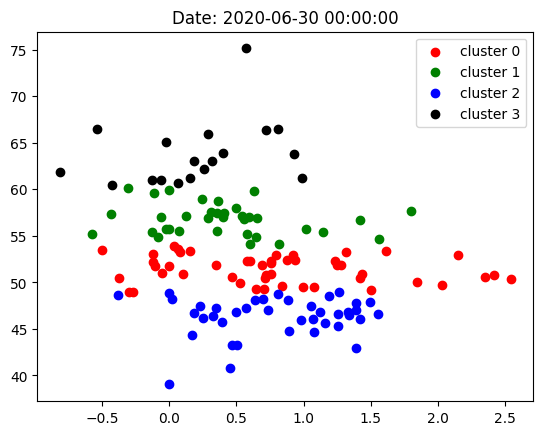

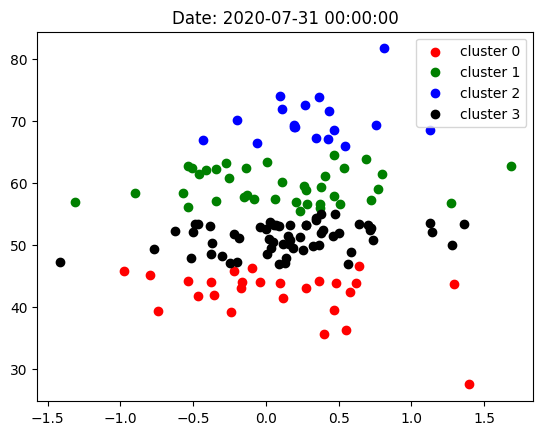

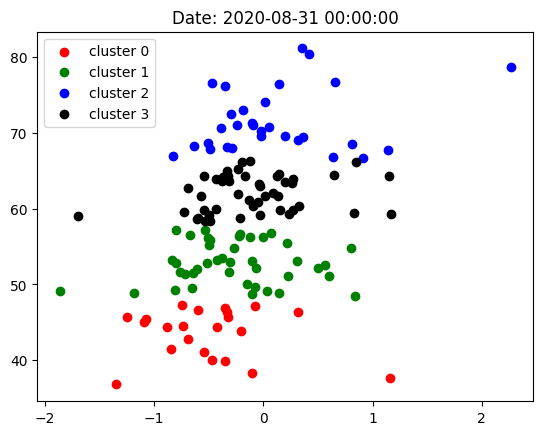

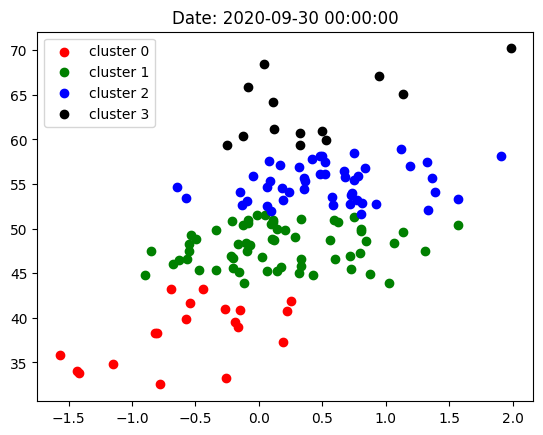

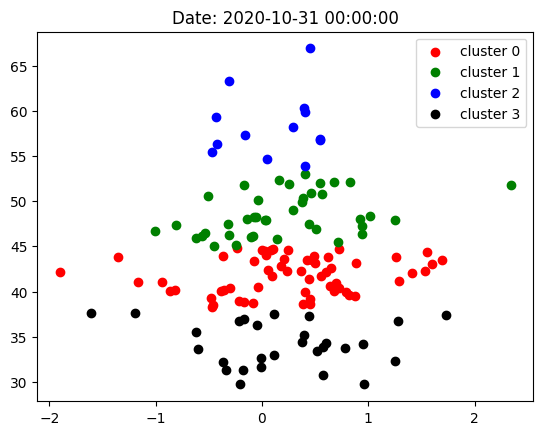

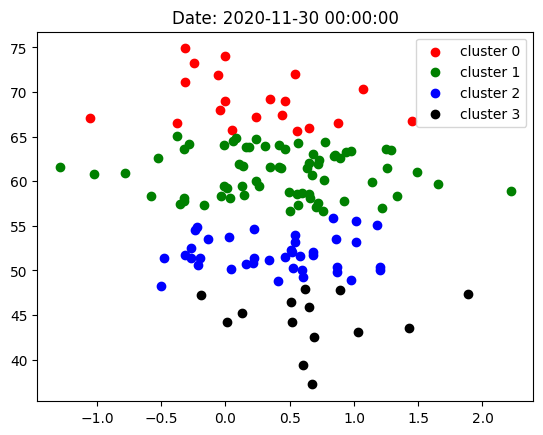

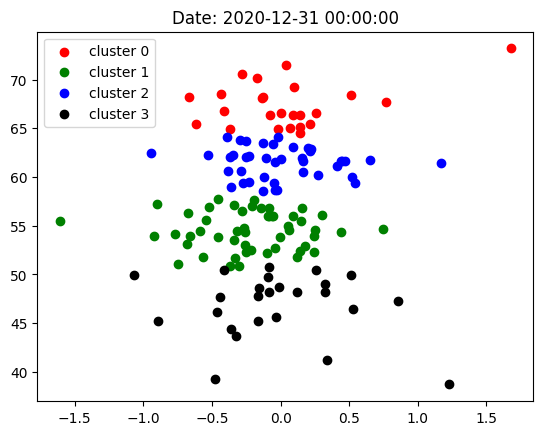

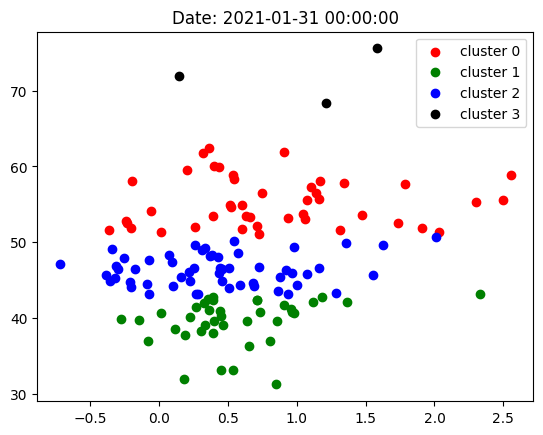

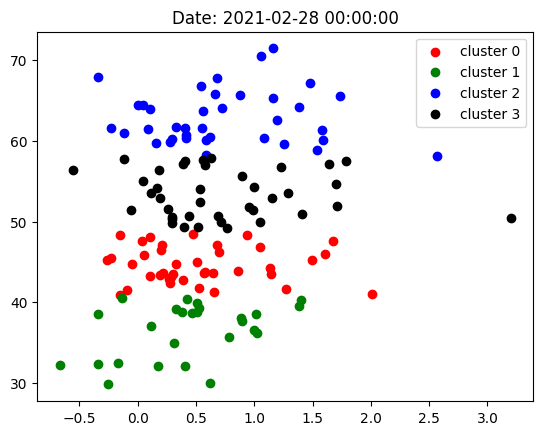

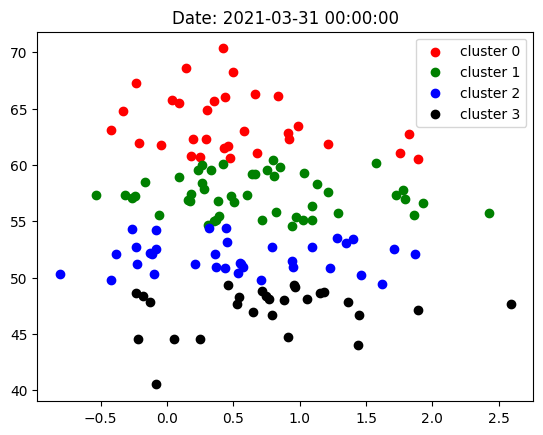

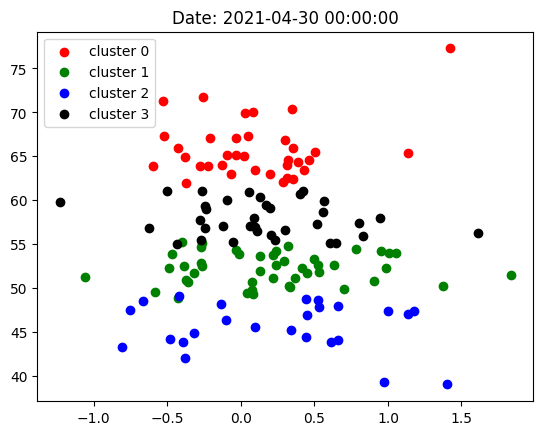

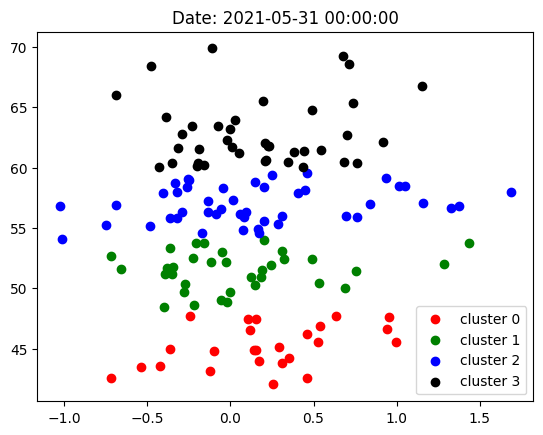

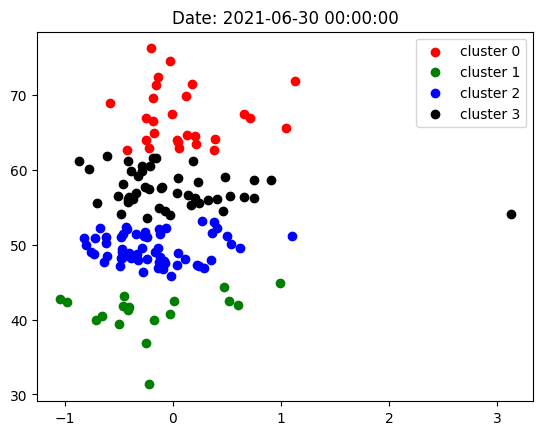

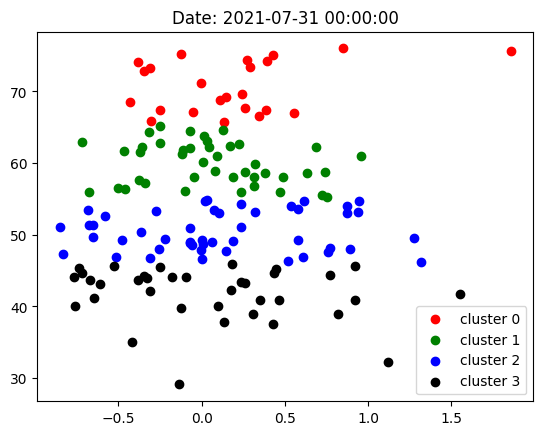

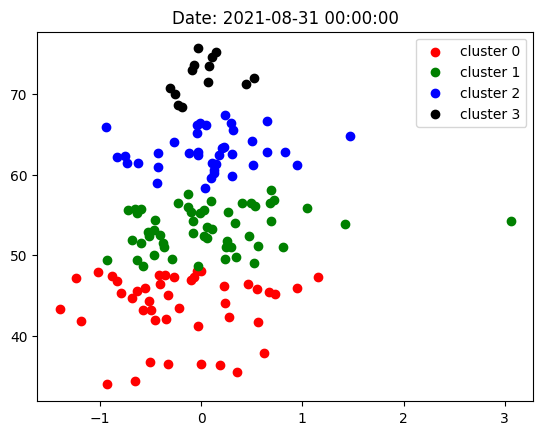

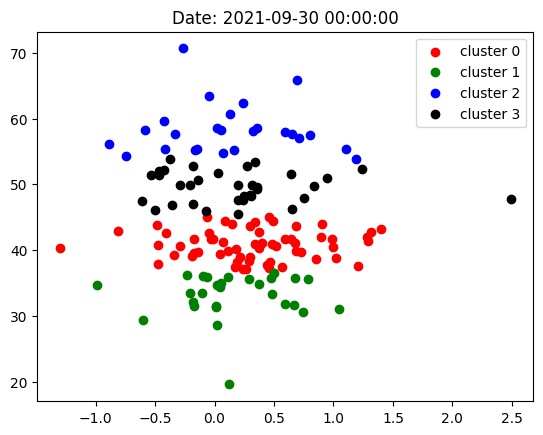

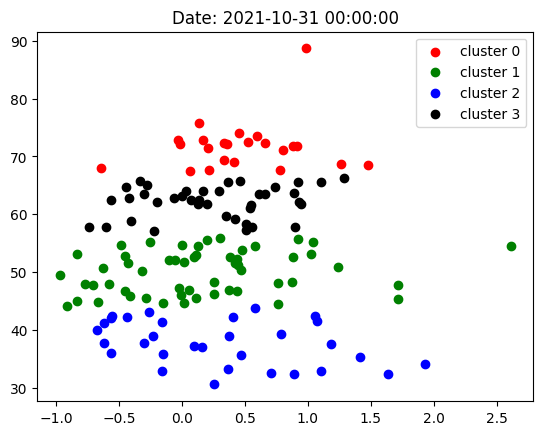

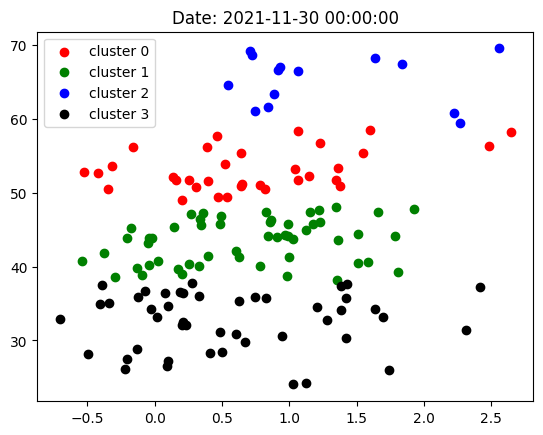

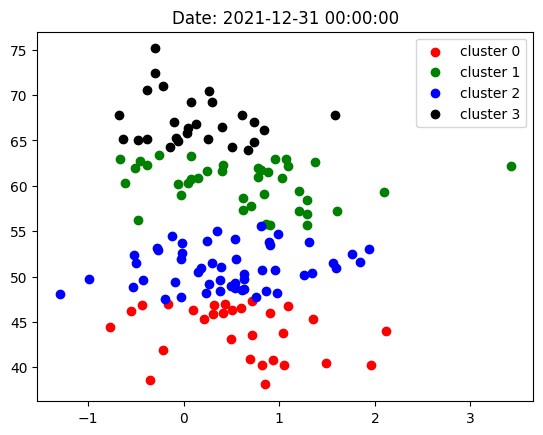

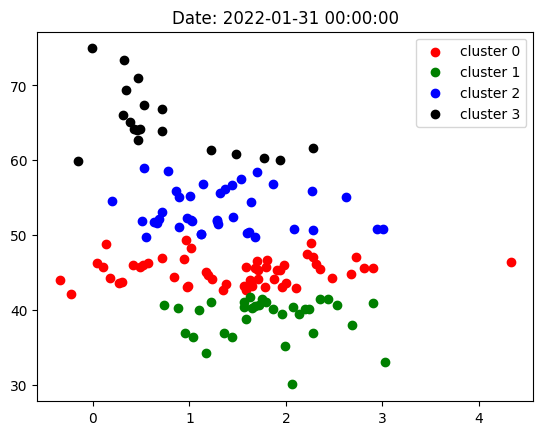

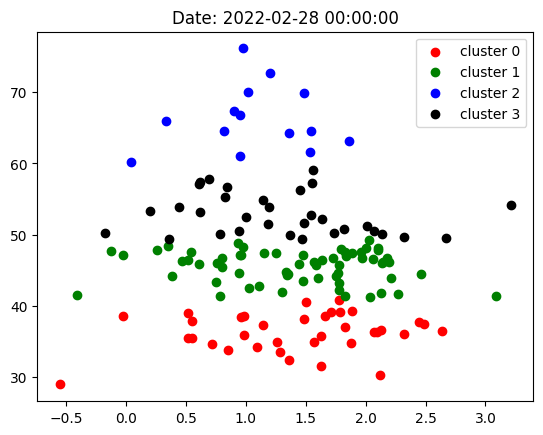

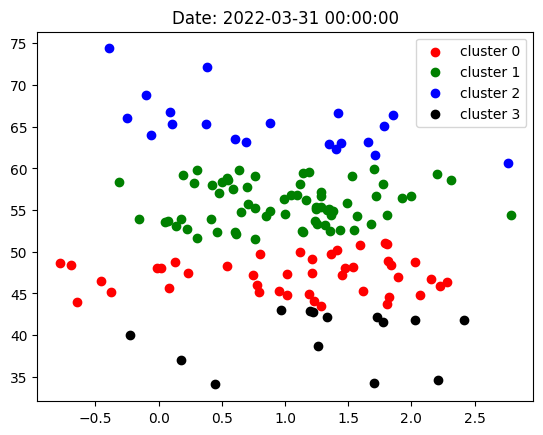

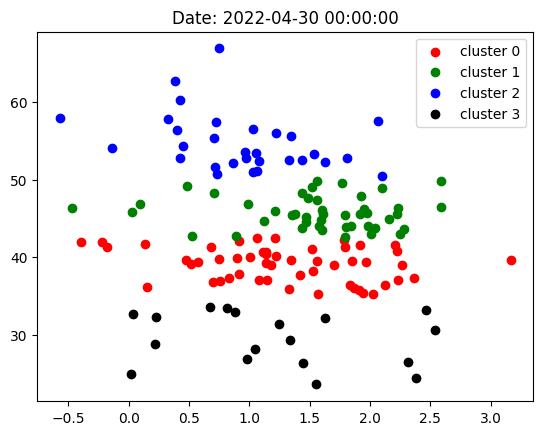

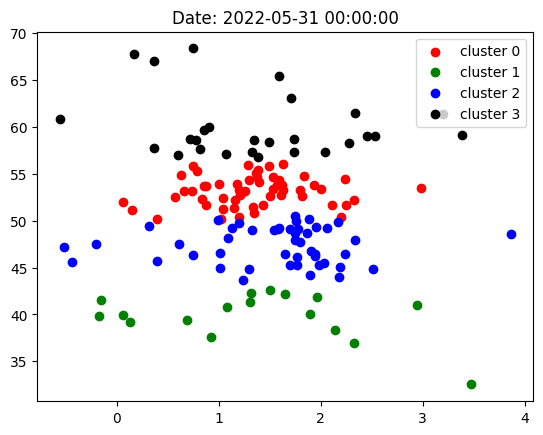

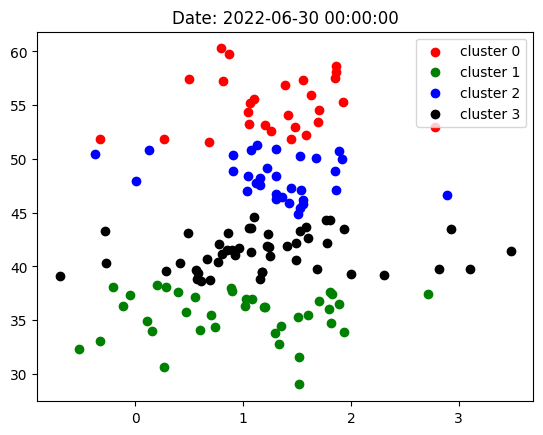

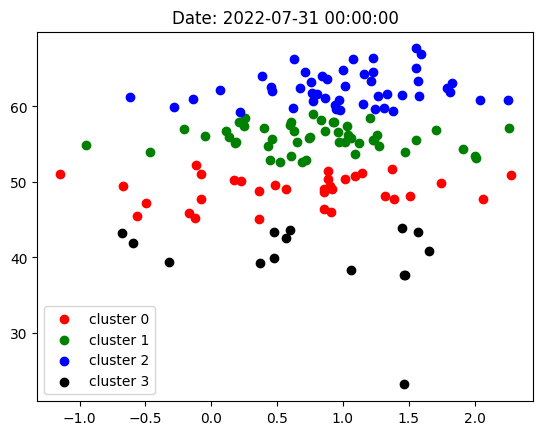

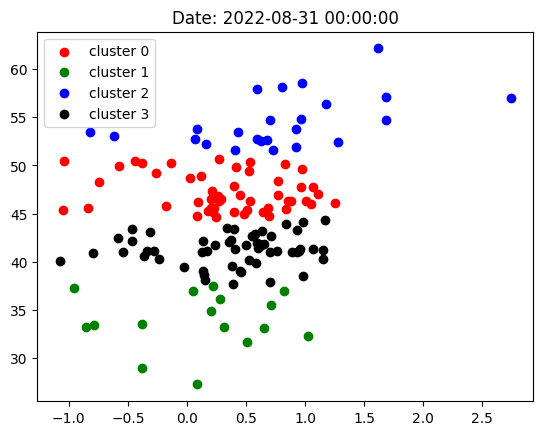

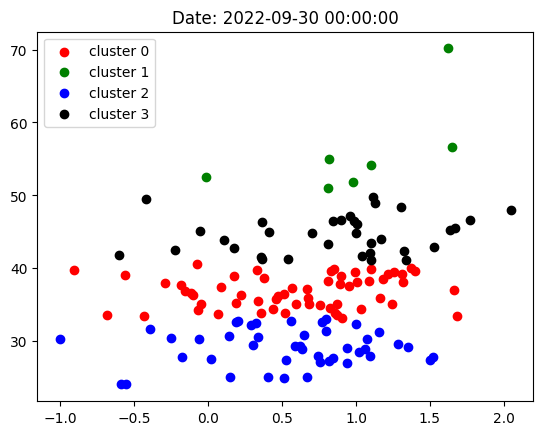

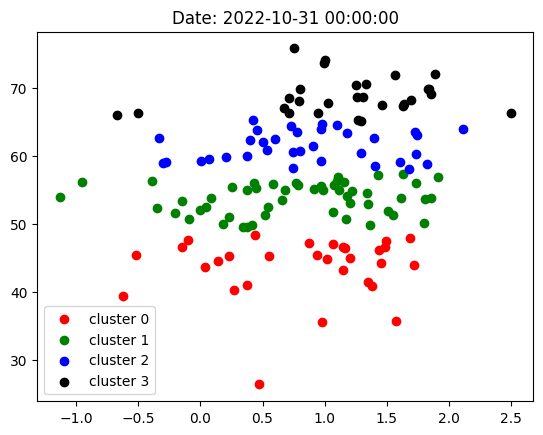

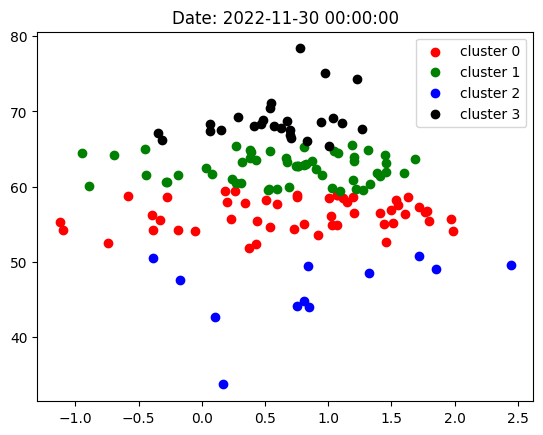

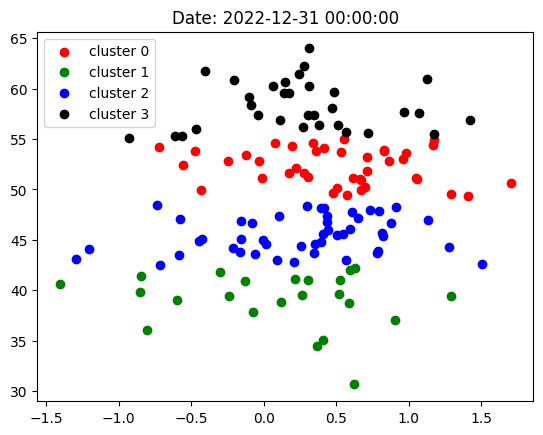

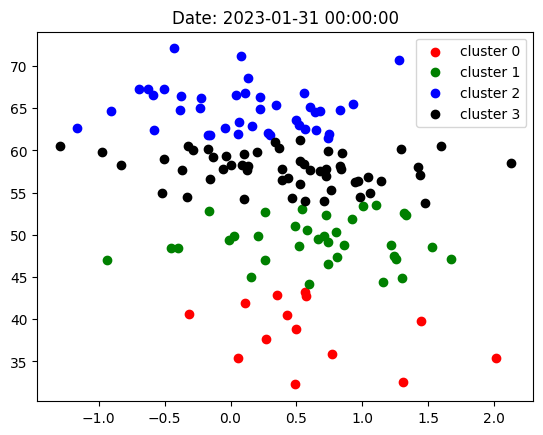

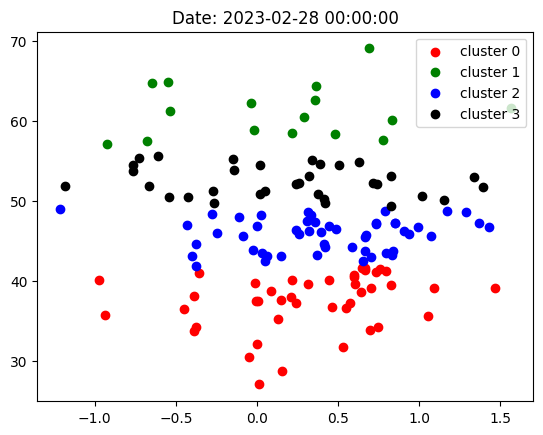

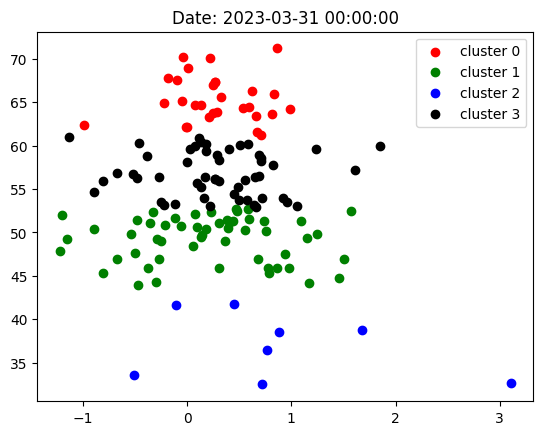

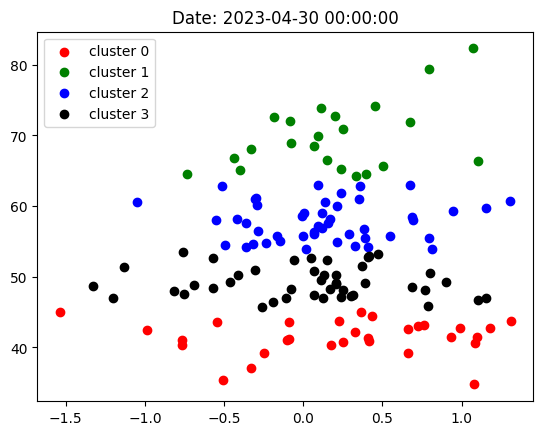

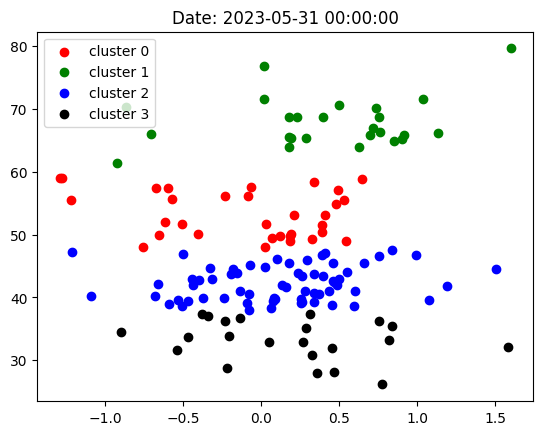

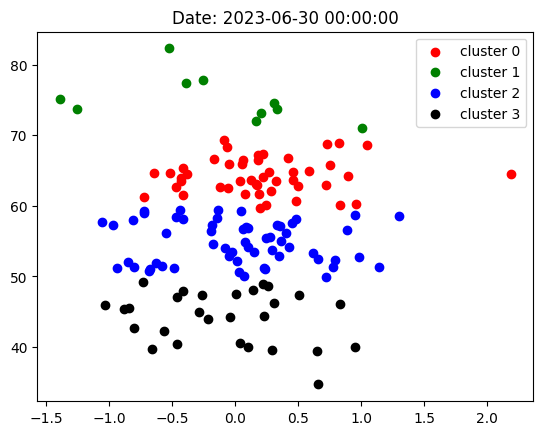

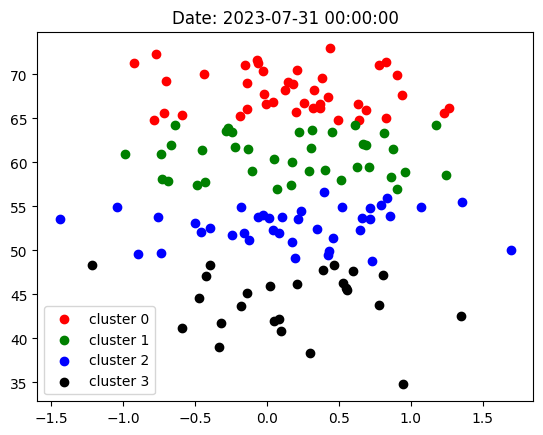

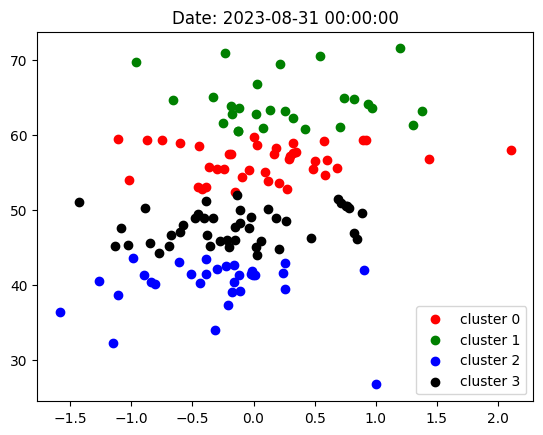

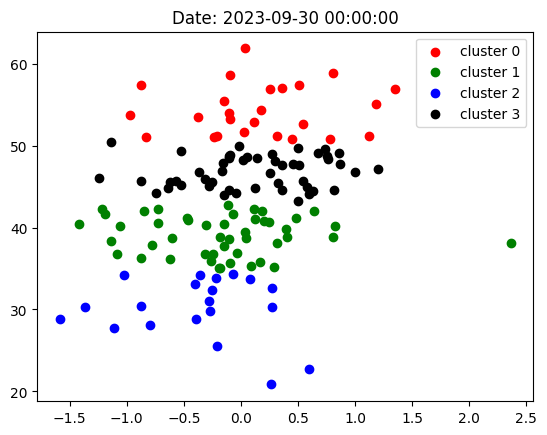

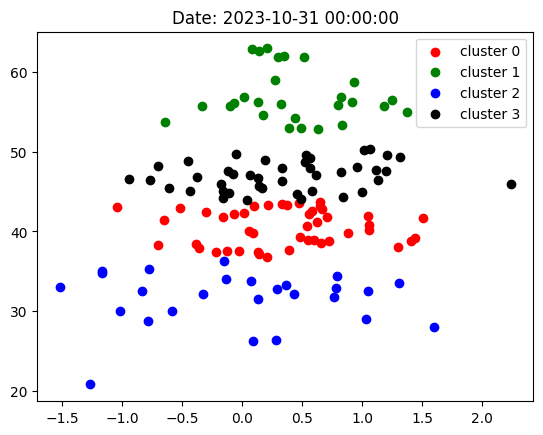

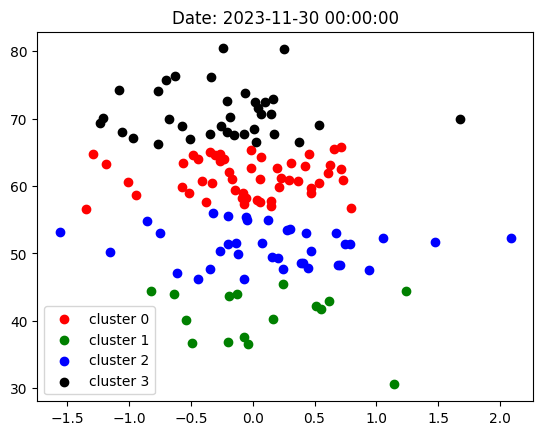

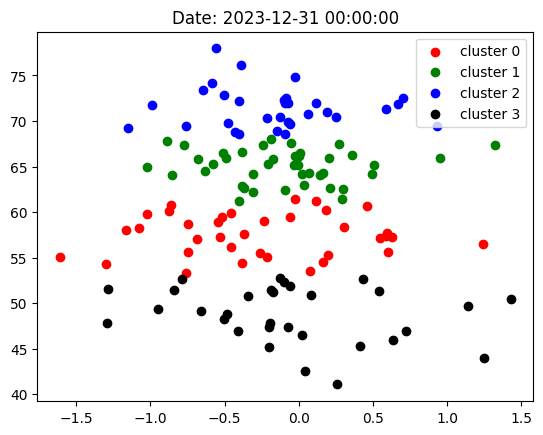

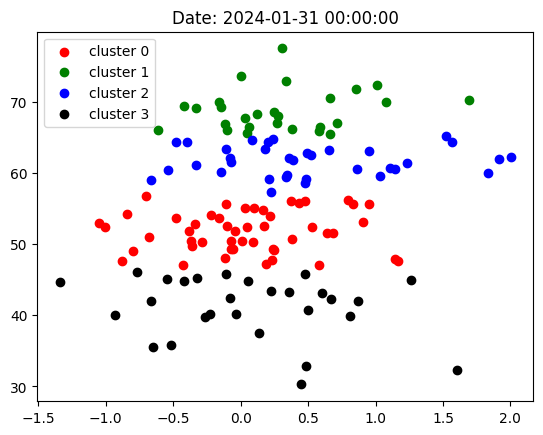

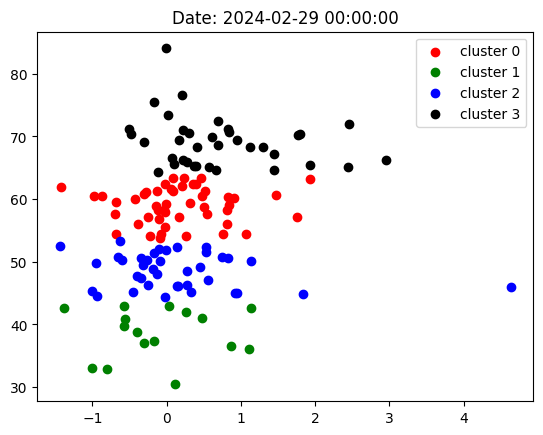

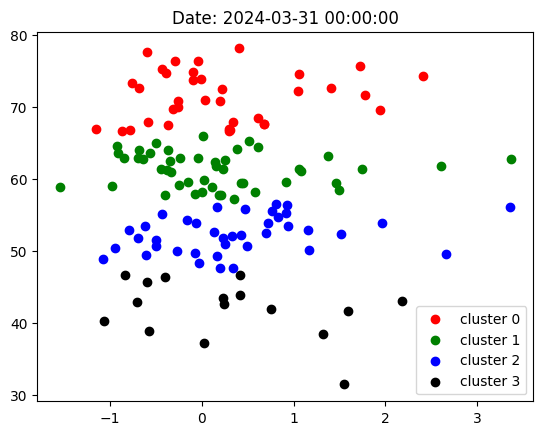

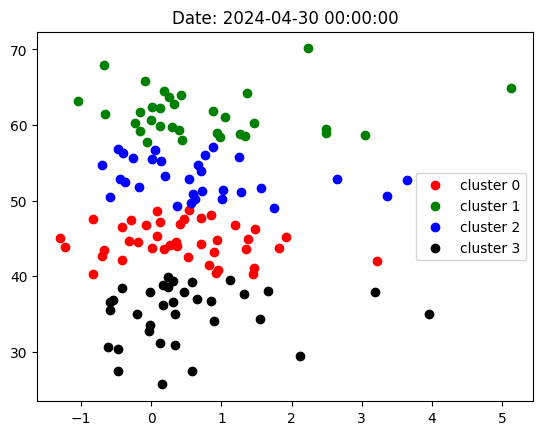

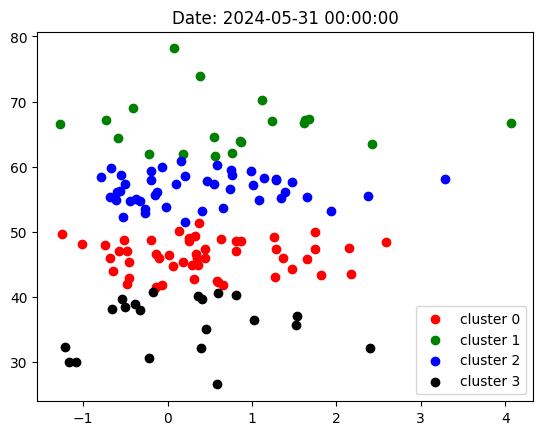

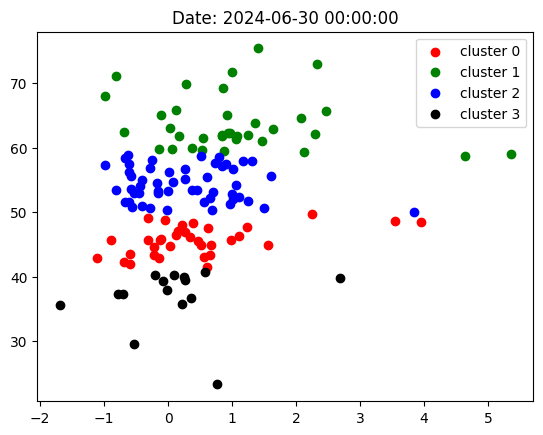

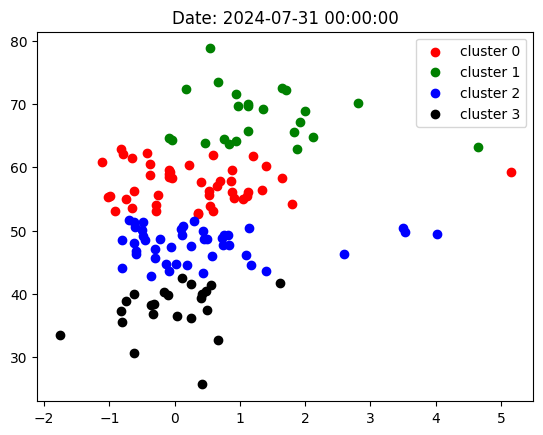

In [28]:
for date in data.index.get_level_values('date').unique().tolist():
    g = data.xs(date,level=0)
    plt.title(f'Date: {date}')
    plot_cluster(g)

## Apply pre-defined centroids.

In [30]:
target_rsi_values = [35,45,55,65]

initial_centroids = np.zeros((len(target_rsi_values), 18))

initial_centroids[:, 6] = target_rsi_values

data = data.drop('cluster', axis=1)

data = data.dropna().groupby('date', group_keys=False).apply(get_clusters, initial_centroids)
data

atr   bb_high    bb_low    bb_mid  garman_klass_vol  \
date       ticker                                                             
2018-07-31 AAL     0.797647  3.699472  3.591910  3.645691          0.000092   
           AAPL   -1.077856  3.860463  3.808181  3.834322         -0.000885   
           ABBV    0.043525  4.341630  4.234662  4.288146         -0.025348   
           ABT    -0.943109  4.114918  4.021121  4.068020         -0.003467   
           ACN    -0.838632  5.058385  4.997519  5.027952         -0.003209   
...                     ...       ...       ...       ...               ...   
2024-07-31 VRTX    1.401704  6.187449  6.144082  6.165765          0.000041   
           VZ     -0.627337  3.759875  3.698250  3.729063          0.000052   
           WFC     0.353646  4.126277  4.044142  4.085210          0.000252   
           WMT     1.353844  4.254243  4.201761  4.228002          0.000154   
           XOM     0.453677  4.770199  4.695178  4.732689          0.000100   

                       macd        rsi  return_1m  return_2m  return_3m  \
date       ticker                                                         
2018-07-31 AAL    -0.292267  49.117682   0.041623  -0.047041  -0.026289   
           AAPL   -0.167589  52.605281   0.027983   0.009109   0.049478   
           ABBV   -0.727461  45.920964   0.005633  -0.029587  -0.011801   
           ABT     0.532793  62.882447   0.079433   0.034388   0.042361   
           ACN    -0.173136  42.887828  -0.026041   0.011460   0.017611   
...                     ...        ...        ...        ...        ...   
2024-07-31 VRTX    1.005346  60.129597   0.012481   0.020898   0.065056   
           VZ      0.593643  56.207534   0.000727   0.001457   0.014805   
           WFC     0.188627  52.822933   0.003873  -0.002506   0.003599   
           WMT     1.859874  69.246723   0.034411   0.032030   0.057975   
           XOM    -0.105252  48.755326  -0.015202  -0.016727  -0.011343   

                   return_6m  return_9m  return_12m    Mkt-RF       SMB  \
date       ticker                                                         
2018-07-31 AAL     -0.050880  -0.017899   -0.019393  1.202351  1.530399   
           AAPL     0.022909   0.014540    0.022060  1.318291 -0.329362   
           ABBV    -0.028860   0.005495    0.026310  0.477698  0.507593   
           ABT      0.010427   0.022867    0.025837  0.787038 -0.128992   
           ACN      0.000037   0.013581    0.019435  1.213826 -0.190196   
...                      ...        ...         ...       ...       ...   
2024-07-31 VRTX     0.015247   0.030507    0.025128  0.509072  0.092526   
           VZ      -0.001627   0.021774    0.020655  0.468967 -0.455634   
           WFC      0.031332   0.048528    0.024058  1.087871 -0.099203   
           WMT      0.042039   0.029537    0.024247  0.616885 -0.391020   
           XOM      0.019371   0.010620    0.007545  1.068891  0.144632   

                        HML       RMW       CMA  cluster  
date       ticker                                         
2018-07-31 AAL     0.397098  0.197188  0.824601        1  
           AAPL   -0.628102  0.427303  0.622960        2  
           ABBV   -0.202950  0.535460  0.469459        1  
           ABT    -0.439233  0.243587  0.934217        3  
           ACN    -0.253431  0.340773  0.082098        1  
...                     ...       ...       ...      ...  
2024-07-31 VRTX   -0.891222  0.067718  0.853537        2  
           VZ      0.229411  0.187554  0.226240        2  
           WFC     1.566559 -0.737992 -0.867370        2  
           WMT    -0.373266  0.212562  0.684859        3  
           XOM     0.842899 -0.485049  0.435617        1  

[10306 rows x 19 columns]

## 7. For each month select assets based on the cluster and form a portfolio based on Efficient Frontier max sharpe ratio optimization

First we will filter only stocks corresponding to the cluster we choose based on our hypothesis.

Momentum is persistent and my idea would be that stocks clustered around RSI 70 centroid should continue to outperform in the following month - thus I would select stocks corresponding to cluster 3.

In [31]:
filter_df = data[data['cluster']==2].copy()

filter_df = filter_df.reset_index(level=1)

filter_df.index = filter_df.index + pd.DateOffset(1)

filter_df = filter_df.reset_index().set_index(['date', 'ticker'])

dates = filter_df.index.get_level_values('date').unique().tolist()

fixed_dates = {}

for d in dates:
    fixed_dates[d.strftime('%Y-%m-%d')] = filter_df.xs(d,level=0).index.tolist()

### Define portfolio optimization function

* We will define a function which optimizes portfolio weights using PyPortfolioOpt package and EfficientFrontier optimizer to maximize the sharpe ratio.

* To optimize the weights of a given portfolio we would need to supply last 1 year prices to the function.

* Apply signle stock weight bounds constraint for diversification (minimum half of equaly weight and maximum 10% of portfolio).

In [32]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

In [33]:
def optimize_weights(prices, lower_bound = 0, upper_bound=0.1):

    returns = expected_returns.mean_historical_return(prices=prices, frequency=252)

    cov = risk_models.sample_cov(prices=prices, frequency=252)

    ef = EfficientFrontier(expected_returns=returns,
                           cov_matrix=cov,
                           weight_bounds=(lower_bound, upper_bound),
                           solver='SCS')
    weights = ef.max_sharpe()

    return ef.clean_weights()
    

Download Fresh Daily Prices Data only for short listed stocks.

In [34]:
stocks = data.index.get_level_values('ticker').unique().tolist()

new_df = yf.download(tickers=stocks,
                     start=data.index.get_level_values('date').unique()[0]-pd.DateOffset(months=12),
                     end=data.index.get_level_values('date').unique()[-1])

new_df

[*********************100%%**********************]  155 of 155 completed


Price       Adj Close                                                  \
Ticker            AAL        AAPL        ABBV         ABT         ACN   
Date                                                                    
2017-07-31  48.955456   34.805637   51.918213   43.763515  115.969177   
2017-08-01  49.557209   35.114536   52.267250   43.736816  116.905449   
2017-08-02  48.965157   36.773724   52.512318   43.808002  115.789139   
2017-08-03  49.062214   36.406322   52.720264   43.745708  117.049477   
2017-08-04  49.304848   36.598217   52.720264   43.834694  117.211510   
...               ...         ...         ...         ...         ...   
2024-06-28  11.330000  210.619995  171.520004  103.910004  303.410004   
2024-07-01  11.040000  216.750000  170.369995  103.199997  302.549988   
2024-07-02  11.050000  220.270004  165.960007  103.199997  303.829987   
2024-07-03  11.120000  221.550003  163.839996  102.330002  305.750000   
2024-07-05  11.040000  226.339996  167.250000  104.019997  299.140015   

Price                                                                  ...  \
Ticker            ADBE         ADI         ADP        ADSK        AIG  ...   
Date                                                                   ...   
2017-07-31  146.490005   69.072235  102.579720  110.790001  54.342350  ...   
2017-08-01  147.360001   69.019783  100.742226  111.379997  54.367256  ...   
2017-08-02  147.130005   68.906143   99.422356  109.129997  54.715973  ...   
2017-08-03  147.789993   68.136856   96.420296  107.879997  54.848820  ...   
2017-08-04  147.710007   67.996956   96.092476  108.389999  54.035141  ...   
...                ...         ...         ...         ...        ...  ...   
2024-06-28  555.539978  228.259995  238.690002  247.449997  74.239998  ...   
2024-07-01  560.010010  225.179993  235.669998  245.830002  74.489998  ...   
2024-07-02  567.710022  228.240005  236.630005  247.860001  75.330002  ...   
2024-07-03  570.150024  230.020004  236.910004  246.300003  75.150002  ...   
2024-07-05  578.340027  230.889999  235.559998  247.869995  73.879997  ...   

Price         Volume                                                  \
Ticker             V      VLO     VRTX        VZ       WBA       WDC   
Date                                                                   
2017-07-31   7576600  7354800  2972700  28456800   4853500   5093600   
2017-08-01   6018100  5330100  1621100  33498200   4892600   4010000   
2017-08-02   5955600  3724900  1781700  19233400   4216400   3757500   
2017-08-03   5697500  3342700  1407100  15190100   4666500   3511100   
2017-08-04   4618000  3201800   807800  13841700   3777300  10704300   
...              ...      ...      ...       ...       ...       ...   
2024-06-28  13957300  3898900  3234600  27639200  54346500   8582800   
2024-07-01   7955800  2205500   950500  16412100  35353800   3605000   
2024-07-02   8697800  2927900   852500  21659400  25951900   2701500   
2024-07-03   5017800  1479900   708700   6653900  26845500   1959000   
2024-07-05   7984500  2416400   848800  17547600  29731000   2313900   

Price                                              
Ticker           WFC       WMT     WYNN       XOM  
Date                                               
2017-07-31  20378100  18789600  2475300  12820200  
2017-08-01  19350300  17179500  2424100  10421200  
2017-08-02  19422100  26019000  2906300  10410100  
2017-08-03  19374700  29840700  1238600  10136700  
2017-08-04  44664600  21425400  1034400   8292200  
...              ...       ...      ...       ...  
2024-06-28  31074500  18816700  2199400  24565900  
2024-07-01  14470200   8666000  1896100  11972900  
2024-07-02   9543700   9436500  2233300  13326700  
2024-07-03   6698800   6287500  1556900   7732900  
2024-07-05  11429300  21582600  1924000  12628700  

[1744 rows x 930 columns]

- Calculate daily returns for each stock which could land up in our portfolio.

- Then loop over each month start, select the stocks for the month and calculate their weights for the next month.

- If the maximum sharpe ratio optimization fails for a given month, apply equally-weighted weights.

- Calculated each day portfolio return.

In [35]:
returns_dataframe = np.log(new_df['Adj Close']).diff()

portfolio_df = pd.DataFrame()

for start_date in fixed_dates.keys():
    
    try:

        end_date = (pd.to_datetime(start_date)+pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')

        cols = fixed_dates[start_date]

        optimization_start_date = (pd.to_datetime(start_date)-pd.DateOffset(months=12)).strftime('%Y-%m-%d')

        optimization_end_date = (pd.to_datetime(start_date)-pd.DateOffset(days=1)).strftime('%Y-%m-%d')
        
        optimization_df = new_df[optimization_start_date:optimization_end_date]['Adj Close'][cols]

        
        success = False
        try:
            weights = optimize_weights(prices=optimization_df,
                                   lower_bound=round(1/(len(optimization_df.columns)*2),3))

            weights = pd.DataFrame(weights, index=pd.Series(0))
            
            success = True
        except:
            print(f'Max Sharpe Optimization failed for {start_date}, Continuing with Equal-Weights')
        
        if success==False:
            weights = pd.DataFrame([1/len(optimization_df.columns) for i in range(len(optimization_df.columns))],
                                     index=optimization_df.columns.tolist(),
                                     columns=pd.Series(0)).T
        
        temp_df = returns_dataframe[start_date:end_date]

        temp_df = temp_df.stack().to_frame('return').reset_index(level=0)\
                   .merge(weights.stack().to_frame('weight').reset_index(level=0, drop=True),
                          left_index=True,
                          right_index=True)\
                   .reset_index().set_index(['Date', 'Ticker']).unstack().stack()

        temp_df.index.names = ['date', 'ticker']

        temp_df['weighted_return'] = temp_df['return']*temp_df['weight']

        temp_df = temp_df.groupby(level=0)['weighted_return'].sum().to_frame('Strategy Return')

        portfolio_df = pd.concat([portfolio_df, temp_df], axis=0)
    
    except Exception as e:
        print(e)
    

portfolio_df = portfolio_df.drop_duplicates()

portfolio_df

'return'


,Strategy Return
date,
2018-08-01,-0.001179
2018-08-02,0.005638
2018-08-03,0.001703
2018-08-06,0.003250
2018-08-07,0.003502
...,...
2024-06-28,-0.000974
2024-07-01,0.001079
2024-07-02,0.001280


## 8. Visualize Portfolio returns and compare to SP500 returns.

In [38]:
aapl = yf.download(tickers='SPY',
                  start='2015-01-01',
                  end=dt.date.today())

aapl_ret = np.log(aapl[['Adj Close']]).diff().dropna().rename({'Adj Close':'SPY Buy&Hold'}, axis=1)

portfolio_df = portfolio_df.merge(aapl_ret,
                                  left_index=True,
                                  right_index=True)

portfolio_df

[*********************100%%**********************]  1 of 1 completed


,Strategy Return,AAPL Buy&Hold,SPY Buy&Hold
2018-08-01,-0.001179,-0.001672,-0.001672
2018-08-02,0.005638,0.005433,0.005433
2018-08-03,0.001703,0.004276,0.004276
2018-08-06,0.003250,0.003660,0.003660
2018-08-07,0.003502,0.003297,0.003297
...,...,...,...
2024-06-27,-0.009499,0.001575,0.001575
2024-06-28,-0.000974,-0.003943,-0.003943
2024-07-01,0.001079,0.002056,0.002056
2024-07-02,0.001280,0.006707,0.006707


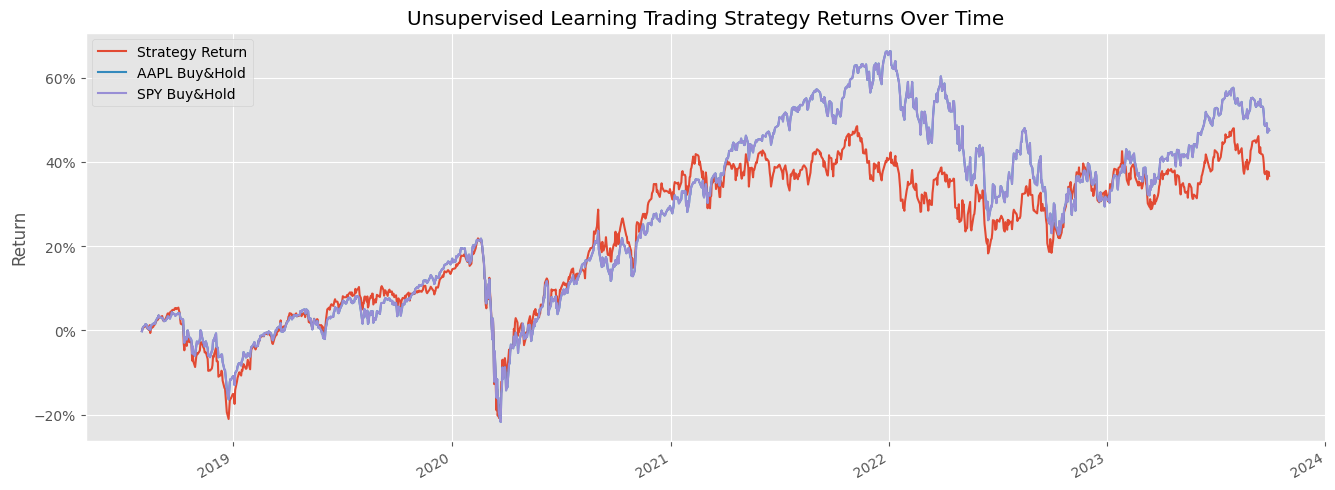

In [39]:
import matplotlib.ticker as mtick

plt.style.use('ggplot')

portfolio_cumulative_return = np.exp(np.log1p(portfolio_df).cumsum())-1

portfolio_cumulative_return[:'2023-09-29'].plot(figsize=(16,6))

plt.title('Unsupervised Learning Trading Strategy Returns Over Time')

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.ylabel('Return')

plt.show()
